In [531]:
import pandas as pd
import glob
import numpy as numpy
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import seaborn as sns
import holidays
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# from nn_train import do_job
import random

# cna not import into global namespace  for multiprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, BatchNormalization, TimeDistributed, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

from multiprocessing import Process, Pool

import os
import multiprocessing as mp
import warnings
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [532]:
EARLIEST_DATE = '2012-01-01'
N_COMPONENTS=100

# REad in data

In [533]:

def read_in_data(check_recent_date=True, recent_date_check=datetime.datetime.now().date()):
    dict_of_stocks_and_dfs = {}
    for file_ in glob.glob('../data/updated_historical_stock_and_etf_data/*.csv'):
        stock_name = file_.rsplit("/")[-1].split('_')[0].lower() 
        print(f"Reading in {stock_name}")
        df_  = pd.read_csv(f"{file_}")
#         try:
#             df_.index = df_.date
#             df_.drop('date', inplace=True)
#         except ValueError:
#             pass
        # ensure we have the most recent data
        try:
            most_recent_date = pd.to_datetime(df_.date.max())
            oldest_date = pd.to_datetime(df_.date.min())
        except Exception:
            continue
        
        oldest_date_bool = oldest_date < datetime.datetime(2010,1,1).date()
        recent_date_bool = most_recent_date == recent_date_check
        
        if oldest_date_bool and recent_date_bool:
            dict_of_stocks_and_dfs[stock_name] = df_.sort_values('date')
        elif oldest_date_bool and not check_recent_date:
            dict_of_stocks_and_dfs[stock_name] = df_.sort_values('date')            
        else:
            print(f"Stock {stock_name} most recent date is {most_recent_date} oldest date is {oldest_date}. Skipping it")
    return dict_of_stocks_and_dfs

In [534]:
dict_of_stocks_and_dfs = read_in_data(recent_date_check=datetime.datetime(2020,6,19).date())

Reading in mcri
Stock mcri most recent date is 2020-06-05 00:00:00 oldest date is 2005-02-25 00:00:00. Skipping it
Reading in amrb
Stock amrb most recent date is 2020-06-05 00:00:00 oldest date is 2005-02-25 00:00:00. Skipping it
Reading in inn
Stock inn most recent date is 2020-06-12 00:00:00 oldest date is 2017-01-03 00:00:00. Skipping it
Reading in so
Reading in ftc
Stock ftc most recent date is 2020-06-05 00:00:00 oldest date is 2017-01-03 00:00:00. Skipping it
Reading in rost
Reading in penn
Stock penn most recent date is 2020-06-05 00:00:00 oldest date is 2005-02-25 00:00:00. Skipping it
Reading in spy
Reading in fitb
Stock fitb most recent date is 2020-06-05 00:00:00 oldest date is 1990-03-26 00:00:00. Skipping it
Reading in boh
Stock boh most recent date is 2020-06-05 00:00:00 oldest date is 2005-02-25 00:00:00. Skipping it
Reading in eqix
Reading in hope
Stock hope most recent date is 2020-06-05 00:00:00 oldest date is 2011-12-05 00:00:00. Skipping it
Reading in well
Stock wel

In [535]:
(len(dict_of_stocks_and_dfs.keys())-1) * len(dict_of_stocks_and_dfs.keys())

1056

In [536]:
len(dict_of_stocks_and_dfs.keys())

33

# Create correlation features

In [538]:
def build_correlation_dfs(dict_of_stocks_and_dfs, n_day_rolling_features_list=[ 3, 7, 30, 180, 365], verbose=False):
    """
    Create correlation + variance based  upon daily closing stock prices for given date ranges
    
    also include daily volume
    
    We are trying to  predict 7 day correaltion
    """

    stock_features_dict = defaultdict(pd.DataFrame)
    start_time = time.time()
    
    start = time.time()
    n_stocks = len(dict_of_stocks_and_dfs.keys())
    final_feature_df = create_date_dummy_df()
    pairs_of_stocks = []
    
    for idx, first_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
        print('')
        print(f"Finished {idx/n_stocks} pct of stocks")
        print('')
        for second_idx, second_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
            stock_pair = f"{first_stock_name}_{second_stock_name}"
            reverse_pair = f"{second_stock_name}_{first_stock_name}"
            
            if (first_stock_name == second_stock_name) or (stock_pair in pairs_of_stocks)  or (reverse_pair in pairs_of_stocks): # pnr -> ual same as ual -> pnr
                continue
            else:
                pairs_of_stocks.append(stock_pair)
            if verbose:
                print('-------')
                print(f"{first_stock_name} & {second_stock_name}")
                print('-------')
            
            # here the date is not the index, yet
            first_stock_df = dict_of_stocks_and_dfs[f"{first_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{first_stock_name}"].date.isin(dict_of_stocks_and_dfs[f"{second_stock_name}"].date), :]

            #  filter second df by the dates in first

            # here the date is not the index, yet
            second_stock_df = dict_of_stocks_and_dfs[f"{second_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{second_stock_name}"].date.isin(first_stock_df.date), :]
            
            # set the date as an index and sort by date
            first_stock_df = first_stock_df.sort_values('date')
            second_stock_df = second_stock_df.sort_values('date')

            first_stock_df = first_stock_df.set_index('date')
            second_stock_df = second_stock_df.set_index('date')
            
            all_features_df = pd.DataFrame()
            for rolling_idx, rolling_day in enumerate(n_day_rolling_features_list):
                if verbose:
                    print(f"Rolling calculations for {rolling_day}")
                features_df = create_correlation_and_variance_features(
                    first_stock_df, second_stock_df, rolling_day, final_feature_df, 
                    first_stock_name=first_stock_name, second_stock_name=second_stock_name)
                   
                current_feature_cols = set(features_df.columns)
                final_feature_cols = set(final_feature_df.columns)

                
                if (f"{first_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{first_stock_name}_volume"] = list(first_stock_df.volume)
                
                if (f"{second_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{second_stock_name}_volume"] = list(second_stock_df.volume)
                    
                if rolling_idx == 0: 
                    all_features_df = features_df
                else:
                    all_features_df = all_features_df.join(features_df, on='date', lsuffix='_left')
            

                    
            all_features_df.index = pd.to_datetime(all_features_df.index)
            final_feature_df = final_feature_df.join(all_features_df, on='date')

            if verbose:
                end = time.time()
                print(f"Building all features took {(end-start)/60} minutes")
                start = time.time()

    end_time = time.time()
    print(f"Total time {(end_time-start_time) / 60} minutes for {len(pairs_of_stocks)} pairs")
    final_feature_df = add_time_feature(final_feature_df)
    return final_feature_df, pairs_of_stocks
            
        

# Note: will eventuall need to add in 0s for stocks withour correlation data with other stocks due to date range
def create_date_dummy_df(start_date=datetime.datetime(1980,1,1), n_years=50):
    
    #  create dummy df with dates to join against
    list_of_dates  = []
    n_days = 365*n_years
    start_date = start_date

    for i in range(n_days):
        list_of_dates.append(start_date + datetime.timedelta(i))
    df_ = pd.DataFrame(list_of_dates, columns=['date'])
    
    df_.date_ =  pd.to_datetime(df_.date)
    return df_.set_index('date')

def add_time_feature(final_stock_df):
    
    days = [i.day for i in final_stock_df.index]
    months = [i.month for i in final_stock_df.index]
    quarters = [i.quarter for i in final_stock_df.index]
    years = [i.year for i in final_stock_df.index]
    
    us_holidays = holidays.UnitedStates()
    
    h_ = np.array([i in us_holidays for i in final_stock_df.index]).astype(int)


    final_stock_df['day'] = days
    final_stock_df['month'] = months
    final_stock_df['quarter'] = quarters
    final_stock_df['year'] = years
#     final_stock_df['is_holiday'] = h_
    
    return final_stock_df

def create_correlation_and_variance_features(first_stock_df, second_stock_df, n_days_stride, final_stock_df, 
                                             first_stock_name=None, second_stock_name=None, verbose=False):
    """
    n_days_stride: the  number of rolling days to calculate correlation for
    """
    n_rows = len(first_stock_df)

    previous_row = 0

    features_per_time_period = defaultdict(list)
    if verbose:
        print(f"Creating correlations + variance on close for {n_days_stride} days")
    
    rolling_close_df = pd.DataFrame(first_stock_df.close.rolling(
        n_days_stride).corr(second_stock_df.close)).rename(
        {'close': f"{first_stock_name}_{second_stock_name}_close_corr_rolling_{n_days_stride}_days"},axis=1).fillna(method='backfill').round(6)

    
    # add cols
    
    current_feature_cols = list(final_stock_df.columns)
    

    # as we go through different pairs will have multiple var / corr for the first stock
    # pnc_bar calcualtes corr for pnr
    #pnr_bat calculates corr for pnr
    # don't want the same cols
    if f"{first_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        
        rolling_close_std_first_stock =  first_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_first_stock
        
    if f"{second_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_close_std_second_stock =  second_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round( 6)
        rolling_close_df[f"{second_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_second_stock
        
    if f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_first_stock =  first_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_first_stock
        
    if f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_second_stock =  second_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_second_stock
    
    return rolling_close_df



In [539]:
# 2 minutes fo 210 pairs
final_stock_df, pairs_of_stocks = build_correlation_dfs(dict_of_stocks_and_dfs, verbose=False)


Finished 0.0 pct of stocks


Finished 0.030303030303030304 pct of stocks


Finished 0.06060606060606061 pct of stocks


Finished 0.09090909090909091 pct of stocks


Finished 0.12121212121212122 pct of stocks


Finished 0.15151515151515152 pct of stocks


Finished 0.18181818181818182 pct of stocks


Finished 0.21212121212121213 pct of stocks


Finished 0.24242424242424243 pct of stocks


Finished 0.2727272727272727 pct of stocks


Finished 0.30303030303030304 pct of stocks


Finished 0.3333333333333333 pct of stocks


Finished 0.36363636363636365 pct of stocks


Finished 0.3939393939393939 pct of stocks


Finished 0.42424242424242425 pct of stocks


Finished 0.45454545454545453 pct of stocks


Finished 0.48484848484848486 pct of stocks


Finished 0.5151515151515151 pct of stocks


Finished 0.5454545454545454 pct of stocks


Finished 0.5757575757575758 pct of stocks


Finished 0.6060606060606061 pct of stocks


Finished 0.6363636363636364 pct of stocks


Finished 0.6666666666666666 pct 

In [540]:
# max number of stocks is ~300 NOT 990

In [541]:
len(final_stock_df.columns)

3007

# Prep code for NN

In [542]:
# prepare the data for LSTM model
def split_sequences(sequences, n_steps, y_col='pg_so_close_corr_rolling_7_days', 
                    start_idx=0, n_val=50, print_idx=100, input_verbose=1,     n_pca_components=100): #2200
    """
    sequences = input_data
    n_steps = n_days of data to give at a time
    
    only works for the currently set y_col
    """
    if y_col not in sequences.columns:
        raise ValueError('This y col does not exist in this df')
    
    X, y = list(), list()
    X_val, y_val = list(), list()
    
    n_sequences = len(sequences)
    print('n_sequences', n_sequences)

    for i in range(start_idx, n_sequences):
        if i == start_idx and input_verbose == 1:
            print(f"Training idx start at {i}")
        if (i % print_idx == 0) and (i != 0) and input_verbose==1:
            print(f"Pct finished = {i/n_sequences}")
            
        # find the end of this pattern
        end_ix = i + n_steps 
        total_end_ix = end_ix + n_val
        # check if we are beyond the dataset
        if (total_end_ix) > n_sequences:
            print(f"Training idx end at {end_ix}")
            print('Total idx checked', total_end_ix)
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = np.array(sequences.loc[:, sequences.columns != f"{y_col}"][i:end_ix]), np.array(
            sequences.loc[:, sequences.columns == f"{y_col}"].shift(-7).fillna(method='ffill').iloc[end_ix-1])

                                 
        X.append(seq_x)
        y.append(seq_y)
    
    val_start_idx = start_idx + n_sequences - (start_idx  + n_val -2)
    for i in range(val_start_idx, n_sequences):
        if i == val_start_idx and input_verbose==1:
            print(f"Val idx start at {val_start_idx}")
        if (i % print_idx == 0) and i != 0 and input_verbose==1:
            print(f"Pct finished for val sequences = {i/n_sequences}")
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences) and input_verbose==1:
            print(f"Val idx end at {end_ix}")
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = np.array(sequences.loc[:, sequences.columns != f"{y_col}"][i:end_ix]), np.array(
            sequences.loc[:, sequences.columns == f"{y_col}"].shift(-7).fillna(method='ffill').iloc[end_ix-1])
        
        
        X_val.append(seq_x)
        y_val.append(seq_y)
    
    

    X, y, X_val, y_val = array(X), array(y), array(X_val), array(y_val)
    
    # errors for standard scaler
    X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
    X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors  
    
    
    scalers = {}
    for i in range(X.shape[1]):
        scalers[i] = StandardScaler()
        X[:, i, :] = scalers[i].fit_transform(X[:, i, :]) 
    X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
    
    pca_scalers = {}

    new_X = np.zeros((X.shape[0], X.shape[1], n_pca_components))
    for i in range(X.shape[1]):
        pca_scalers[i] = PCA(n_components=n_pca_components) # ~80%
        new_X[:, i, :] = pca_scalers[i].fit_transform(X[:, i, :]) 


    for i in range(X_val.shape[1]):
        X_val[:, i, :] = scalers[i].transform(X_val[:, i, :]) 

    X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors  

    new_X_val = np.zeros((X_val.shape[0], X_val.shape[1], n_pca_components))
    for i in range(X_val.shape[1]):
        new_X_val[:, i, :] = pca_scalers[i].transform(X_val[:, i, :]) 
        
   # need  to do this again as standard scaler may have nans
    X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
    X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors 
    print('X val shape', X_val.shape)
    

    
    return new_X, y, new_X_val, y_val, scalers, pca_scalers

    
    

In [543]:
def build_keras_model(n_steps, n_features, n_units=50, dropout_pct=0.02, n_layers = 1):
    model = Sequential()


    # define CNN model
#     model.add(TimeDistributed(Conv2D(n_units, kernel_and_pool_size))
#     model.add(TimeDistributed(MaxPooling2D(pool_size=kernel_and_pool_size))
#     model.add(TimeDistributed(Flatten()))

        
    model.add(LSTM(n_units, activation='relu', dropout=dropout_pct, return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(BatchNormalization())
    for _ in range(n_layers):
        model.add(LSTM(n_units, activation='relu', dropout=dropout_pct, return_sequences=True))
        model.add(BatchNormalization())
    model.add(LSTM(n_units, activation='relu', dropout=dropout_pct))
    model.add(BatchNormalization())
    model.add(Dense(n_units))
    model.add(Dense(int(n_units/2)))
    model.add(Dense(1))
    #Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    #LR = 0.0001
    #clipnorm=1., clipvalue=0.5
    model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='mse', metrics=['mse'])
    return model

# Train a model

In [544]:
np.sqrt(.4)

0.6324555320336759

In [545]:
# train on all data
# predict for the upcoming week

# 
def prediction_for_upcoming_week(final_stock_df,pairs_of_stocks,  job_id=None, print_idx=25, n_day_sequences=14, 
                                 start_date_training_data='2009-01-01', n_validation_sequences=25, input_batch_size=128, 
                                 input_verbose=0, min_val_mse_threshold=0.25, n_pca_components=100):
    """
    The main entrypoint for training an LSTM network on stock predictions
    
    :param final_stock_df: The list of stock pairs with correlations over different time ranges, volume
    :para pairs_of_stocks: The list of stock pairs
    :param print_idx: The number of iterations to pass before printing out progress
    :param n_day_sequences: The number of sequences to pass to the LSTM (i.e. the number of days)
    :param start_date_training_data: Filter for data before thie date to train on
    :param n_validation_sequences: Number of sequences to validate on. Should be >= 20
    :param input_batch_size: size of the batches for training NN
    :parm input_verbose: if 1, print out everything otherwise, don't
    :param min_val_mse_threshold: the minimum val mse in order to consider these stocks predictions for the upcoming week. 
    :param n_pca_components: Number of components for PCA. 100 is >99% of variance
    """
    #validate
    if n_validation_sequences < 20:
        raise ValueError('Incorrect n_validation_sequences')
    
    n_stock_missed_val_threshold = 0
    # validation needs to be 40 or index error
    final_stock_df = final_stock_df.dropna()
    final_stock_df = final_stock_df.sort_values(by='date')
    # add this to predictions
    stock_to_industry = pd.read_csv('../data/Industries stock list - all.csv')
    stock_to_industry.symbol = [i.lower() for i in stock_to_industry.symbol]

    final_stock_df = final_stock_df.dropna()
    most_recent_date = final_stock_df.index.max()

    prediction_end = most_recent_date + datetime.timedelta(7)



    test_df = final_stock_df.iloc[-n_day_sequences:, :]

    

    n_days_corr_predictions = 7


    pct_change_corr = []
    predicted_corr = []
    last_corr_for_prediction_day = []
    
    pred_dates= []
    first_stock_industries = []
    second_stock_industries = []
    
    first_model = True

    start_final_time = time.time()
    total_n = len(pairs_of_stocks)
    
    for idx,stock_pairing in enumerate(pairs_of_stocks):
        if idx % print_idx == 0:
            print('----------')
            print(f"Stock pairing = {stock_pairing}")
            print(f"Pct finished = {idx/total_n}")
        first_stock_name, second_stock_name = stock_pairing.split('_')

        first_stock_industries.append(stock_to_industry[stock_to_industry.symbol == first_stock_name].industry.values[0])
        second_stock_industries.append(stock_to_industry[stock_to_industry.symbol == second_stock_name].industry.values[0])



        pred_col_name = f"{stock_pairing}_close_corr_rolling_{n_days_corr_predictions}_days"
        print('pred_col_name', pred_col_name)

        # remove the current 7-day corr for this stock
        # for 7 take rolling 7 days corr to the present day to predict off of
        
        ## TRAINING AND TESTING DATA
        X,y, X_val, y_val, scalers, pca_scalers = split_sequences(
            final_stock_df[final_stock_df.index  >= f"{start_date_training_data}"],
            n_day_sequences, start_idx=0, input_verbose=1,
            n_val=n_validation_sequences, y_col=f"{pred_col_name}", n_pca_components=n_pca_components
        ) # 30 steps
        
        train_X, train_y = final_stock_df.loc[:, final_stock_df.columns != f"{pred_col_name}"],  final_stock_df[f"{pred_col_name}"].shift(-7).fillna(method='ffill') 
                                                           # get corr from 7 days in the future
        test_X, test_y = np.array(test_df.loc[:, test_df.columns != f"{pred_col_name}"]),  test_df[f"{pred_col_name}"]
        test_X = test_X.reshape(1, test_X.shape[0], test_X.shape[1])
        test_X = np.nan_to_num(test_X.astype(np.float32))
        
        for i in range(test_X.shape[1]):
            test_X[:, i, :] = scalers[i].transform(test_X[:, i, :]) 
        test_X = np.nan_to_num(test_X.astype(np.float32))
        
        new_X_test = np.zeros((test_X.shape[0], test_X.shape[1], n_pca_components))
        for i in range(test_X.shape[1]):
            new_X_test[:, i, :] = pca_scalers[i].transform(test_X[:, i, :]) 

        ## END TRAINING AND TESTING DATA 
        
        
        if first_model:
            print('building model')
            smaller_model = build_keras_model(X.shape[1],X.shape[2])
            print(smaller_model.summary())
            
        # test again at 700 epochs
        if first_model:
            start = time.time()
            # 800 epochs
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=400, verbose=1, restore_best_weights=True)
            print('starting training')
            history = smaller_model.fit(x=X, y=y, batch_size=input_batch_size, epochs=800, verbose=input_verbose, 
                      validation_data=(X_val, y_val), shuffle=False,  use_multiprocessing=False, callbacks=[early_stopping])
            end=time.time()

            print((end-start)/60,' minutes')
        else:

            # Freeze the layers except the last 5 layers
            for layer in smaller_model.layers[:-3]:
                layer.trainable = False
            # Check the trainable status of the individual layers

            smaller_model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='mse', metrics=['mse'])
            
            start = time.time()
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, restore_best_weights=True)

            history = smaller_model.fit(x=X, y=y, batch_size=input_batch_size, epochs=200, verbose=input_verbose, 
                      validation_data=(X_val, y_val), shuffle=False,  use_multiprocessing=False, callbacks=[early_stopping])
            end=time.time()
            print((end-start)/60,' minutes')

    
        history_df  = pd.DataFrame(history.history)
        history_df[['mse', 'val_mse']].iloc[-200:, :].plot()
        min_val_mse = np.min(history_df['val_mse'])
        min_train_mse = np.min(history_df['mse'])
        plt.show()
        prediction = smaller_model.predict(new_X_test)[0][0] 

        if idx % print_idx==0:
            print(f"Prediction = {prediction}")



        last_corr_date = train_y.index.max()
        last_corr = train_y[train_y.index.max()]  
        if idx % print_idx==0:
            print(f"Last corr = {last_corr}")
        
        if (min_val_mse <= min_val_mse_threshold) and (min_train_mse <= min_val_mse_threshold):
            pred_dates.append(most_recent_date)
            predicted_corr.append(prediction)
            last_corr_for_prediction_day.append(last_corr)
        else:
            pred_dates.append(most_recent_date)
            predicted_corr.append(99999999)
            last_corr_for_prediction_day.append(last_corr)
            n_stock_missed_val_threshold+=1
        
        if input_verbose==1 and idx % print_idx==0:
            print(f"{stock_pairing} corr7-day corr of close from {most_recent_date} to {prediction_end} is {prediction} ")
        
        first_model = False
        
        # write the predictions for every predictions
        squarred_difference = (np.array(last_corr_for_prediction_day)-np.array(predicted_corr))**2

        prediction_df = pd.DataFrame({ 'pred_date_start':pred_dates,'stock_pair':pairs_of_stocks[:idx+1],   'first_stock_industry': first_stock_industries, 
                   'second_stock_industry': second_stock_industries,
                   'predicted_corr': predicted_corr, 'last_7_day_corr_for_pred_date_start': last_corr_for_prediction_day, 
            'squarred_diff_7_day_cor': (np.array(last_corr_for_prediction_day)-np.array(predicted_corr))**2,
                                      'absolute_value_from_0':abs(np.array(predicted_corr))
                 })
        
        prediction_df.to_csv(
    f'../data/predictions/lstm_test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)


    end_final_time = time.time()

    print(f"Predictions took {(end_final_time-start_final_time)/60} mins")


    
#     if job_id:
#         tmp_filepath = '../data/lstm_tmp_prediction_dfs'
#         if not os.path.isdir(f"{tmp_filepath}"):
#             os.mkdir(f"{tmp_filepath}")
#         prediction_df.to_csv(
#         f'{tmp_filepath}/{job_id}_lstm_test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)
#     else:
  


In [546]:
# def chunks(l, n):
#     return [l[i:i+n] for i in range(0, len(l), n)]



# def dispatch_jobs(data, job_number, pairs):
#     total = len(pairs)
#     chunk_size = total / job_number
#     slice = chunks(pairs, int(chunk_size))
#     jobs = []
#     executor = ProcessPoolExecutor(max_workers=5, mp_context=mp.get_context("spawn"))
#     i = 1
#     pair = slice[0]
#     print(pair)
#     executor.map(do_job, (pair, data, 1))


# #     for i, pair in enumerate(slice):
# #         print(i)
        
# #         j = Process(target=do_job, args=(i, pair, data))
# #         jobs.append(j)
        

# #         executor.map(do_job, (i, pair, data))


        
# #         executor.submit(do_job)
# #     for j in jobs:
# #         j.start()
        
# # def main():
# #     executor = ProcessPoolExecutor(mp_context=mp.get_context("spawn"), max_workers=5)
# #     task1 = executor.submit(task)
# #     task2 = executor.submit(task)acorr

In [547]:
# from concurrent.futures import ProcessPoolExecutor
# import multiprocessing as mp

# # # from external import just_print

# executor = ProcessPoolExecutor(mp_context=mp.get_context("spawn"), max_workers=5)


# if __name__ == '__main__':
#     num_workers=3
# #     dispatch_jobs(final_stock_df, num_workers , pairs_of_stocks[:100])
    
#     executor = ProcessPoolExecutor(max_workers=5, mp_context=mp.get_context("spawn"))
#     i = 1


#     executor.map(do_job, (pairs_of_stocks[:10], final_stock_df, 1))

In [548]:
# if __name__ == '__main__':
#     mp.set_start_method('spawn', force=True)
#     final_stock_df = final_stock_df.dropna()
#     num_workers = mp.cpu_count()  
#     num_workers=2
#     dispatch_jobs(final_stock_df, num_workers , pairs_of_stocks[:100])

In [549]:

random.shuffle(pairs_of_stocks)

In [550]:
len(pairs_of_stocks)

528

----------
Stock pairing = vti_pvh
Pct finished = 0.0
pred_col_name vti_pvh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.869867780097425

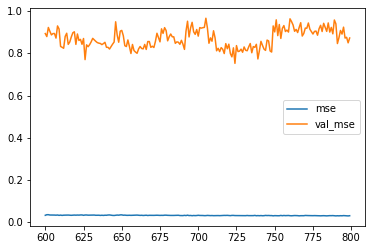

Prediction = 0.6699594259262085
Last corr = -0.292542
pred_col_name emr_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.869867780097425

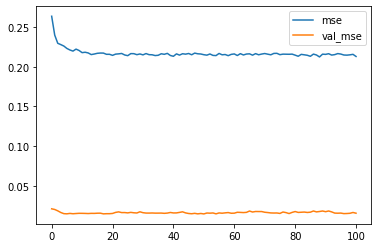

pred_col_name pvh_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

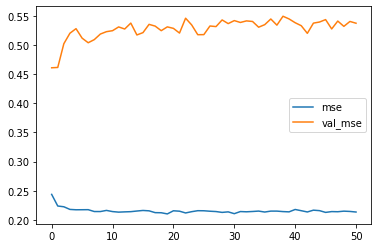

pred_col_name are_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

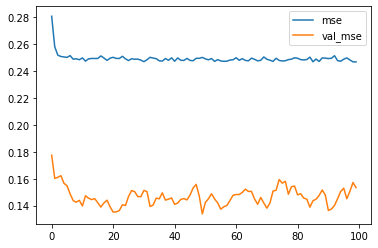

pred_col_name tjx_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

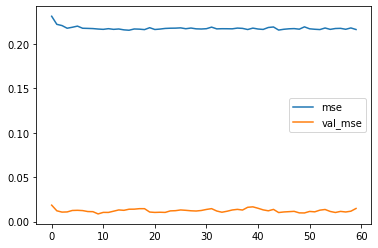

pred_col_name ce_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

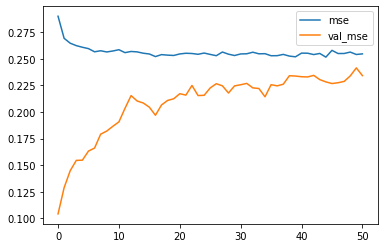

pred_col_name rop_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

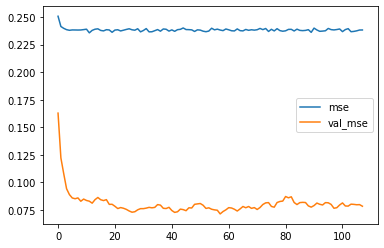

pred_col_name eqix_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

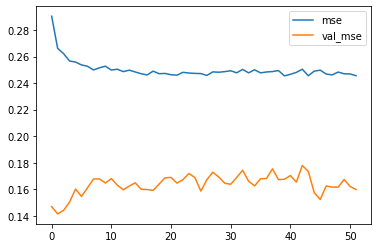

pred_col_name pbj_qqq_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

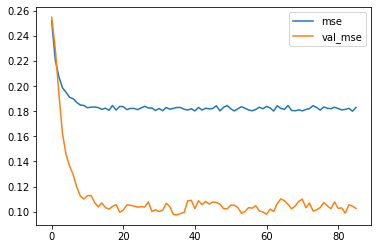

pred_col_name vfh_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

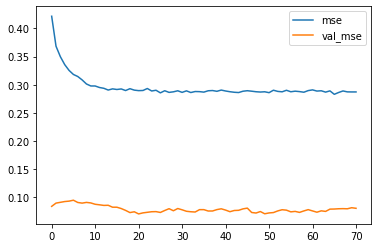

pred_col_name spy_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

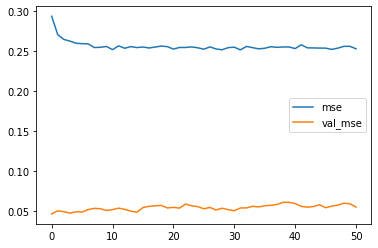

pred_col_name bjk_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

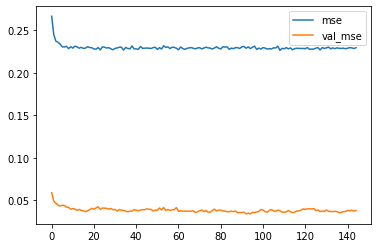

pred_col_name dia_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

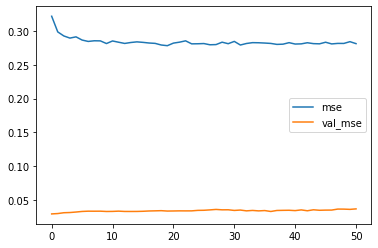

pred_col_name rop_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

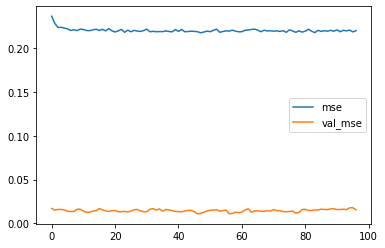

pred_col_name vfh_emr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

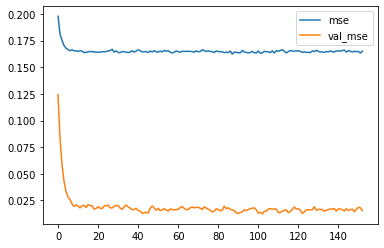

pred_col_name so_rost_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

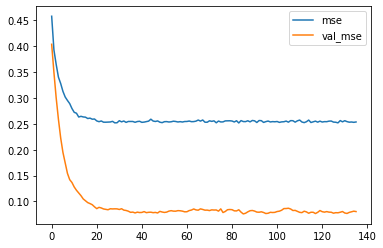

pred_col_name so_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.939

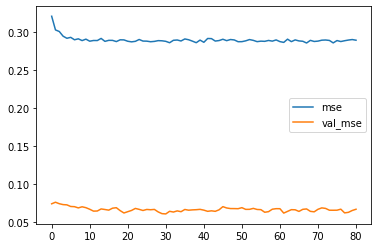

pred_col_name vfh_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

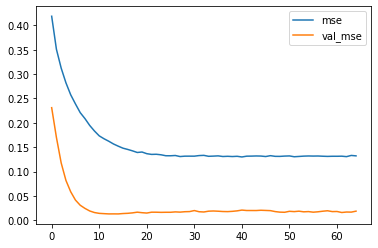

pred_col_name iwm_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

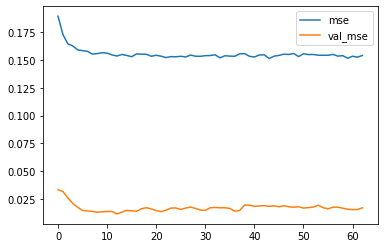

pred_col_name qqq_emr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

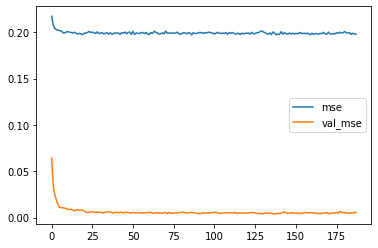

pred_col_name ni_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

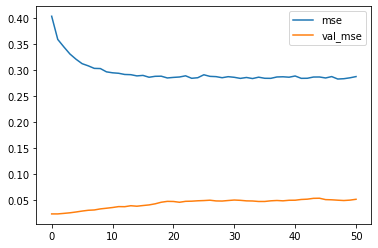

pred_col_name vti_ce_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

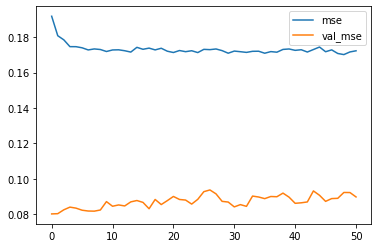

pred_col_name eqix_ce_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

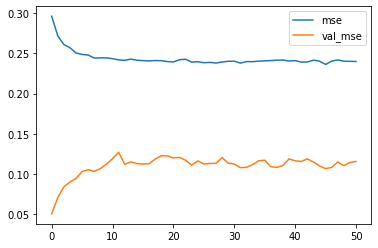

pred_col_name xrt_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

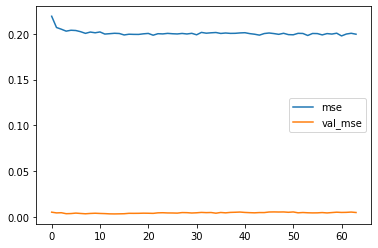

pred_col_name vfh_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

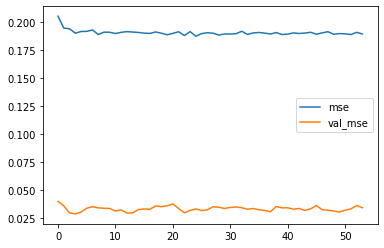

----------
Stock pairing = ce_iwm
Pct finished = 0.04734848484848485
pred_col_name ce_iwm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8

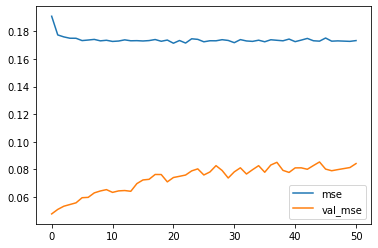

Prediction = 0.7398827075958252
Last corr = 0.886126
pred_col_name tjx_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252

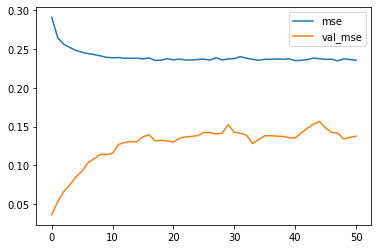

pred_col_name vti_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

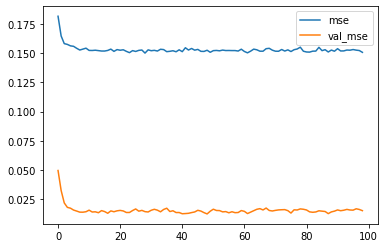

pred_col_name iwm_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

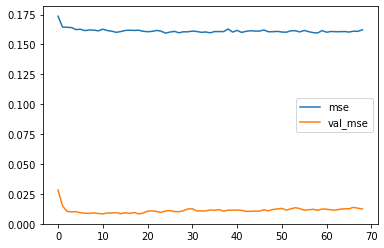

pred_col_name ce_emr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

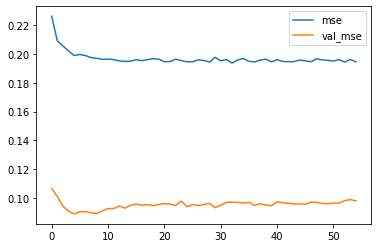

pred_col_name jpm_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

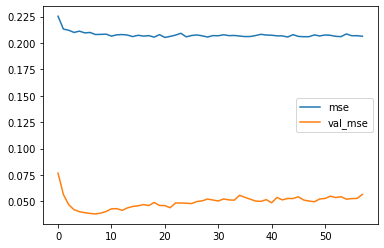

pred_col_name spy_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

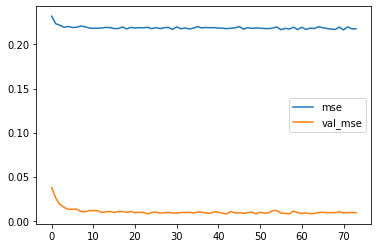

pred_col_name eqix_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0

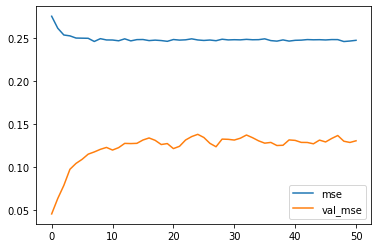

pred_col_name vfh_pg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

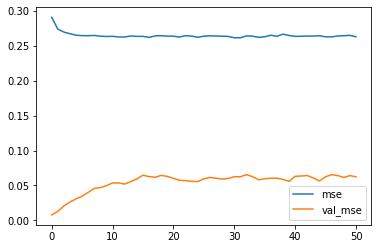

pred_col_name atvi_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

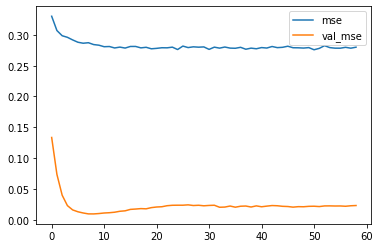

pred_col_name vfh_atvi_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

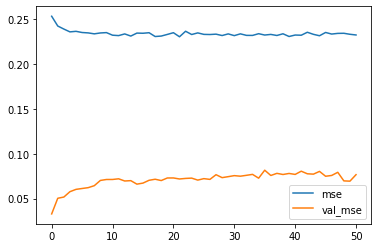

pred_col_name cern_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

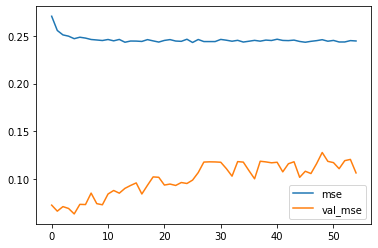

pred_col_name spy_iwm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

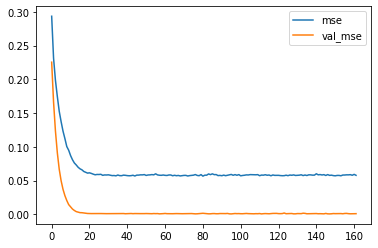

pred_col_name dia_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

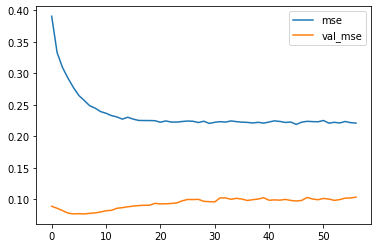

pred_col_name pbj_iwm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

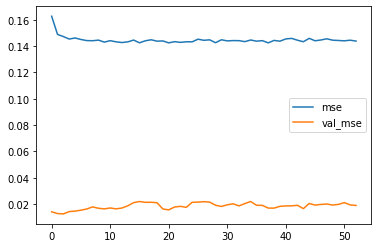

pred_col_name jpm_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

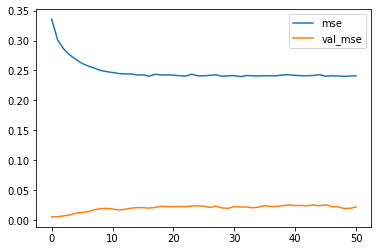

pred_col_name eqix_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0

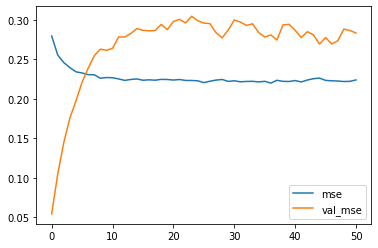

pred_col_name pej_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

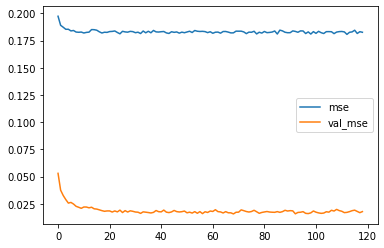

pred_col_name are_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

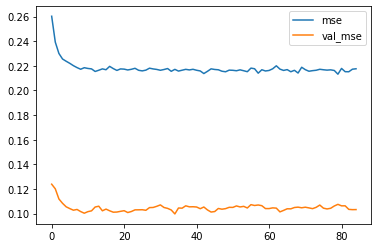

pred_col_name emr_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

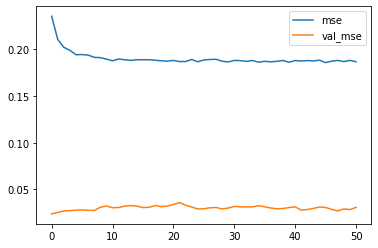

pred_col_name eqix_pbj_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

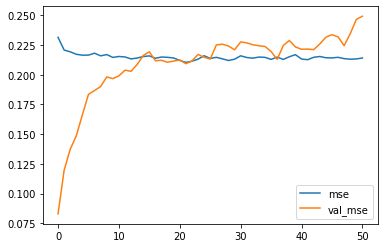

pred_col_name so_spy_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

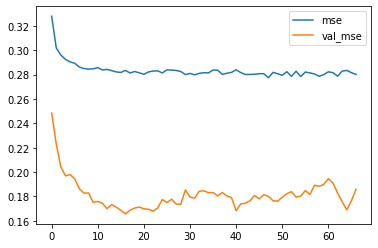

pred_col_name spy_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

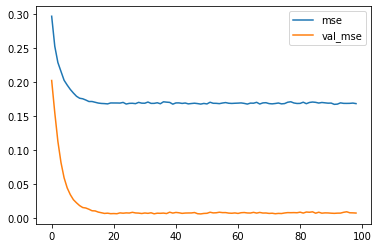

pred_col_name eqix_qqq_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

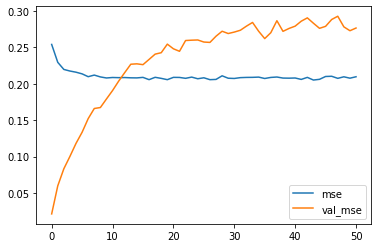

pred_col_name rop_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

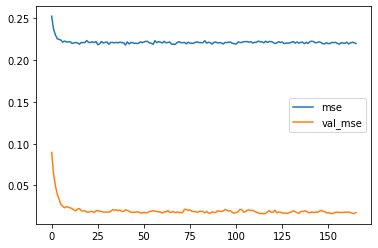

----------
Stock pairing = eqix_iwm
Pct finished = 0.0946969696969697
pred_col_name eqix_iwm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 

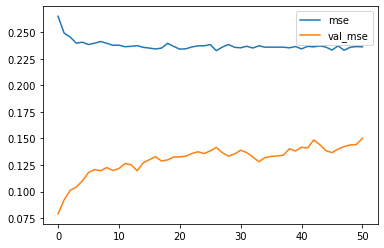

Prediction = 0.5420889854431152
Last corr = 0.832842
pred_col_name eqix_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252

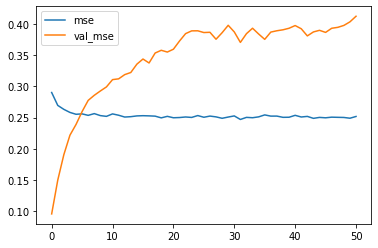

pred_col_name spy_jpm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

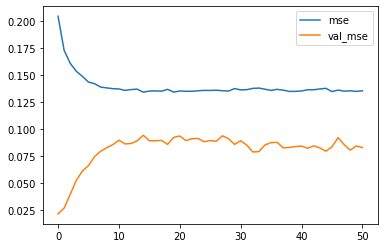

pred_col_name iwm_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

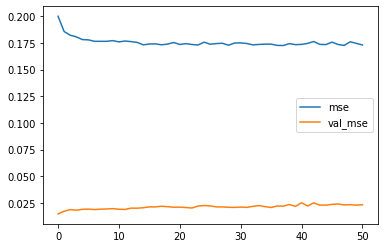

pred_col_name pbj_pvh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

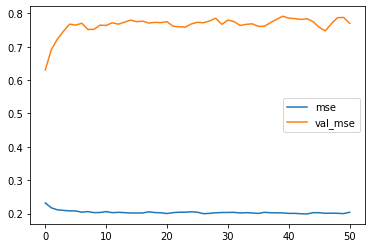

pred_col_name pbj_emr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

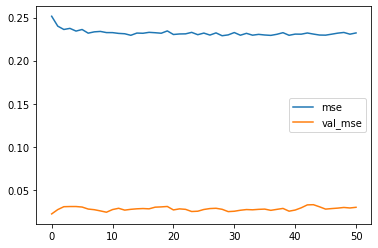

pred_col_name vti_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

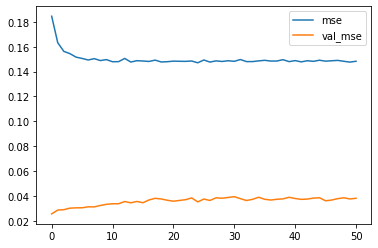

pred_col_name vfh_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

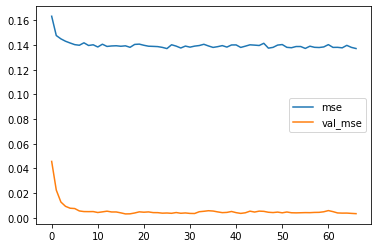

pred_col_name rost_atvi_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0

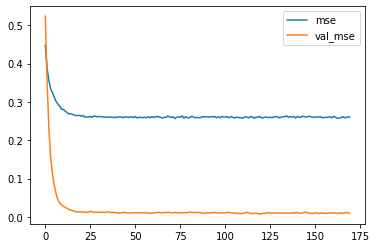

pred_col_name vfh_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

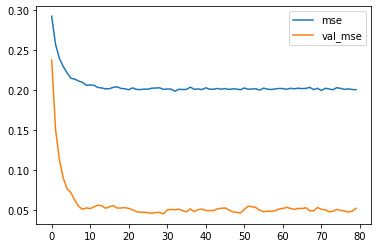

pred_col_name are_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

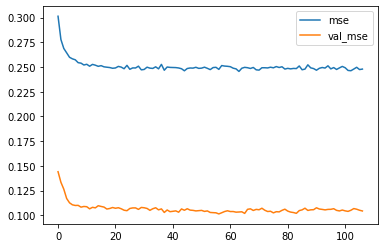

pred_col_name spy_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

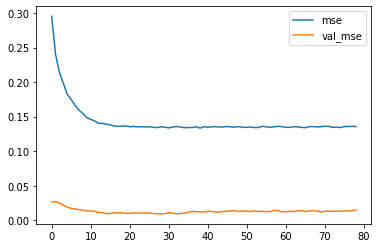

pred_col_name mgm_dia_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

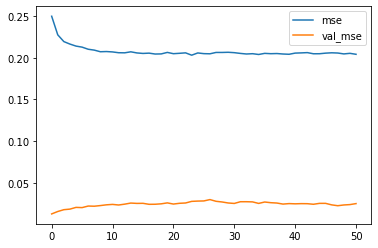

pred_col_name eqix_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

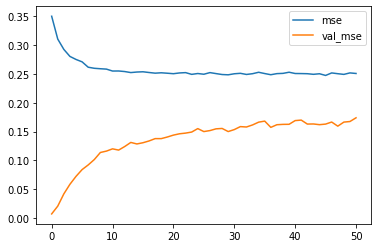

pred_col_name pvh_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

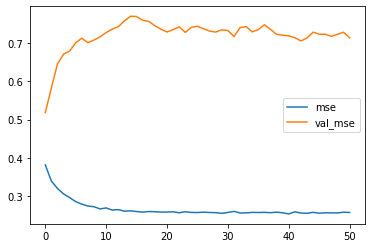

pred_col_name emr_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

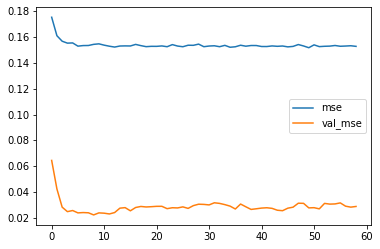

pred_col_name emr_lb_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

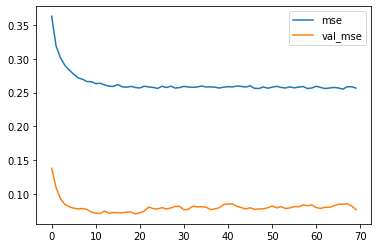

pred_col_name ce_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

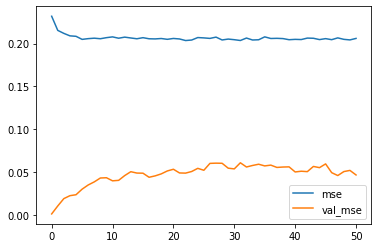

pred_col_name ce_tjx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

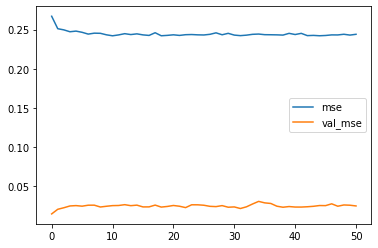

pred_col_name pbj_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

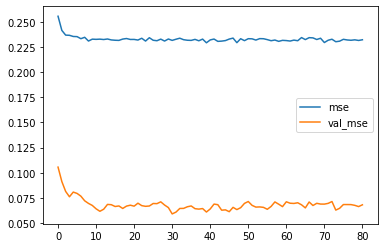

pred_col_name tjx_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

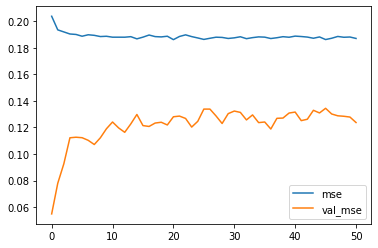

pred_col_name vti_vfh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

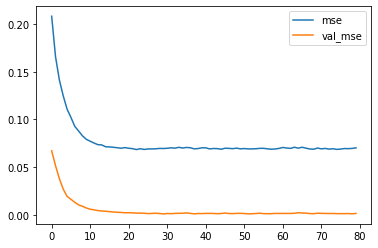

pred_col_name ce_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

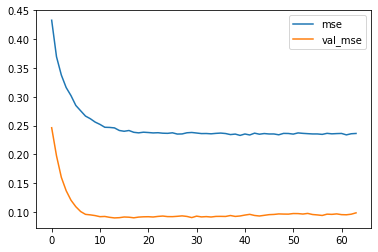

pred_col_name atvi_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

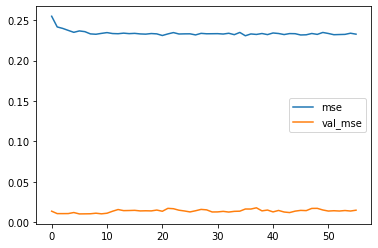

pred_col_name eqix_vti_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

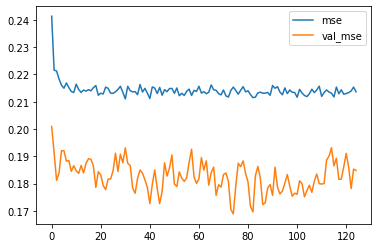

----------
Stock pairing = emr_dia
Pct finished = 0.14204545454545456
pred_col_name emr_dia_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0

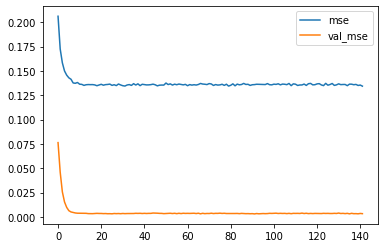

Prediction = 0.868291974067688
Last corr = 0.84438
pred_col_name iwm_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
P

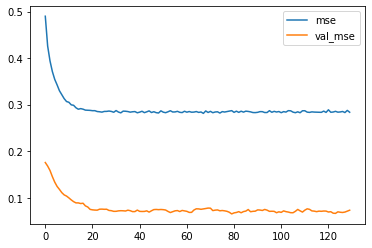

pred_col_name emr_mgm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

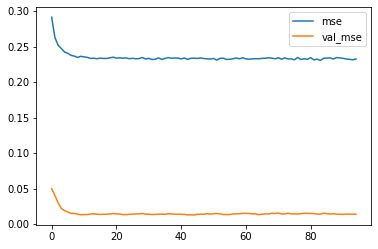

pred_col_name tjx_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

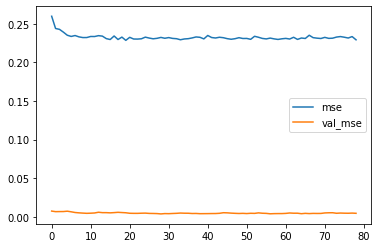

pred_col_name pvh_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

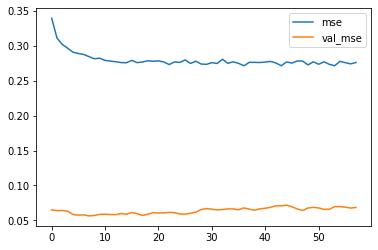

pred_col_name atvi_tjx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

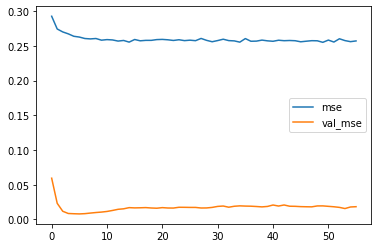

pred_col_name vti_tjx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

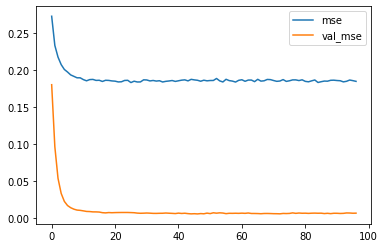

pred_col_name vfh_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

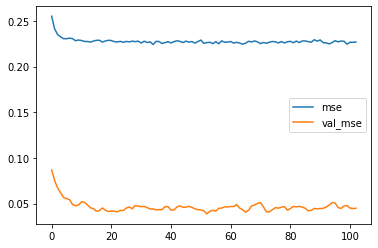

pred_col_name adbe_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

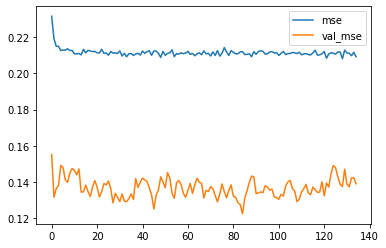

pred_col_name so_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.939

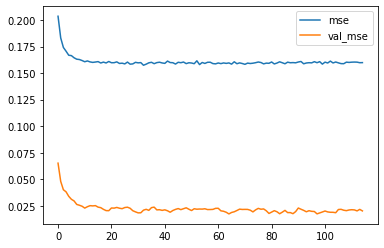

pred_col_name mgm_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

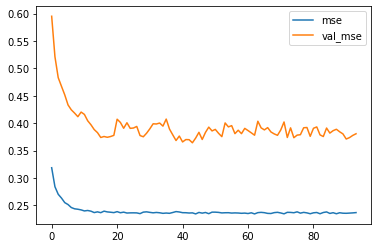

pred_col_name vti_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

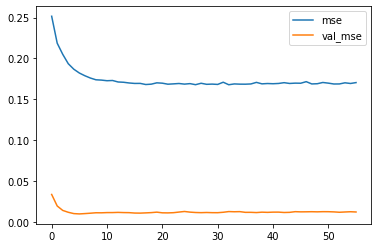

pred_col_name vti_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

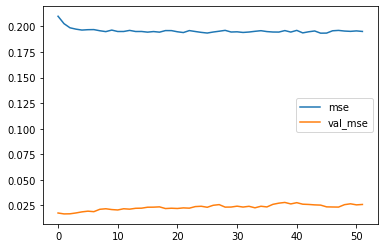

pred_col_name ce_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

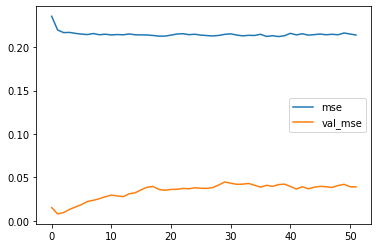

pred_col_name eqix_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

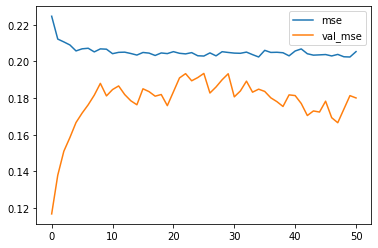

pred_col_name emr_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

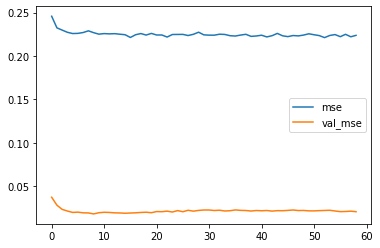

pred_col_name iwm_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

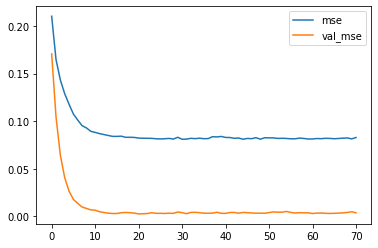

pred_col_name iwm_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

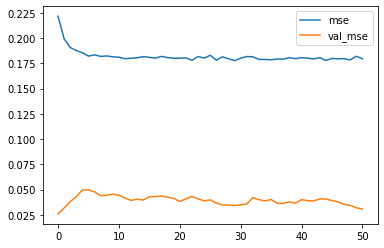

pred_col_name mgm_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

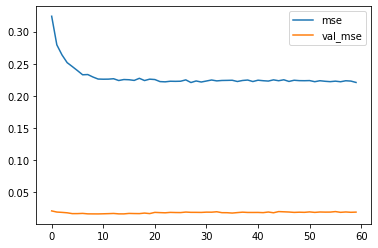

pred_col_name vti_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

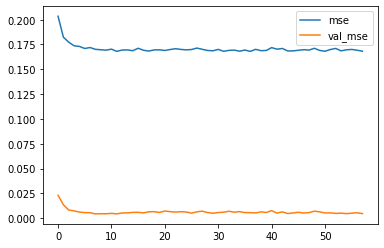

pred_col_name rost_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

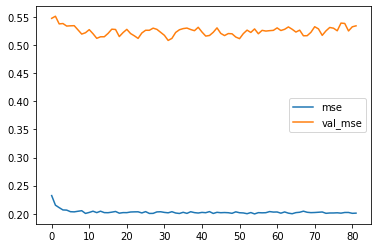

pred_col_name iwm_pvh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

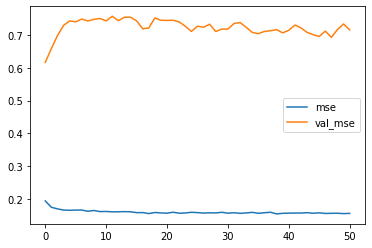

pred_col_name peg_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

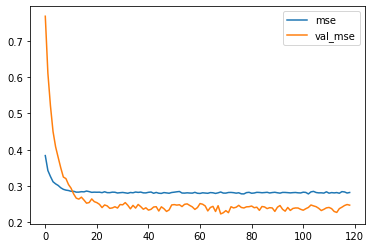

pred_col_name qqq_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

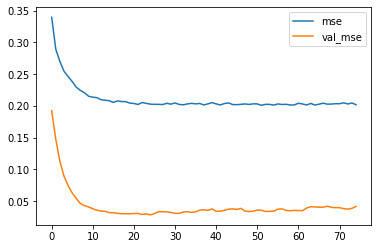

pred_col_name eqix_mgm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

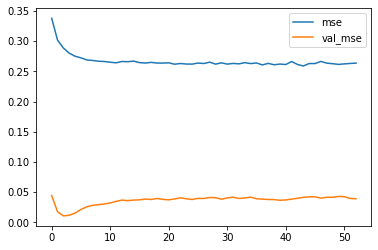

----------
Stock pairing = pbj_peg
Pct finished = 0.1893939393939394
pred_col_name pbj_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.

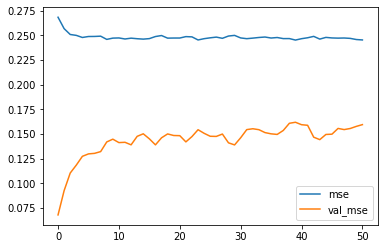

Prediction = 0.4807441830635071
Last corr = 0.226646
pred_col_name pg_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252


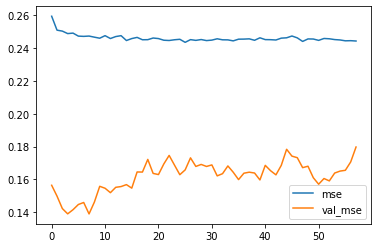

pred_col_name rost_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

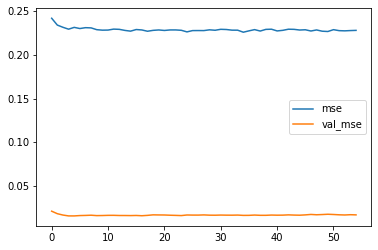

pred_col_name rost_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

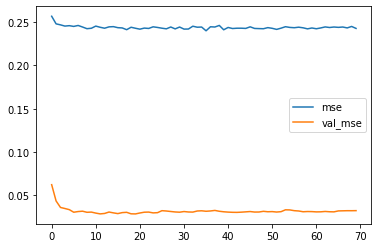

pred_col_name ni_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

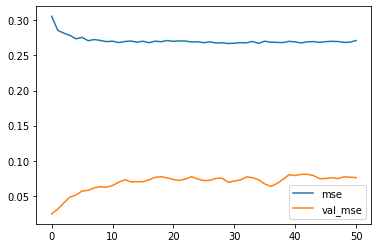

pred_col_name iwm_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

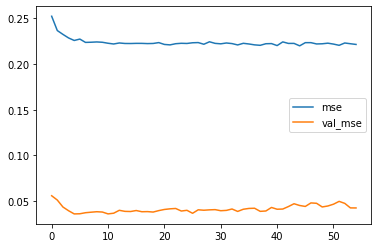

pred_col_name rost_pbj_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

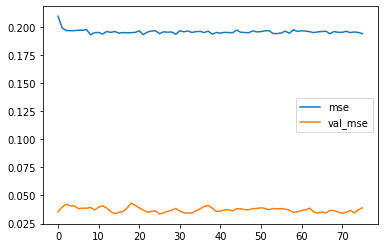

pred_col_name pvh_lb_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

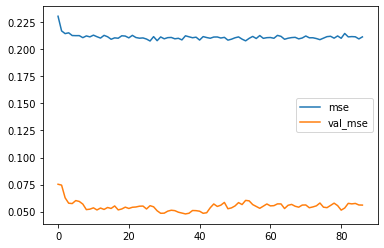

pred_col_name mgm_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

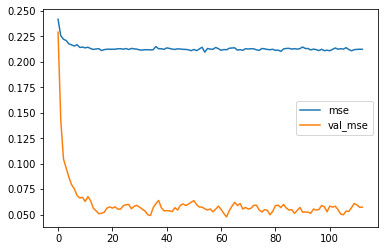

pred_col_name so_pbj_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

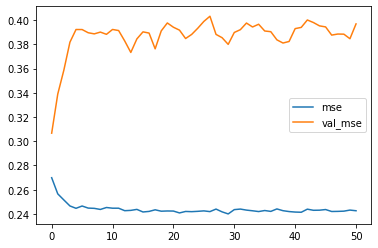

pred_col_name bac_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

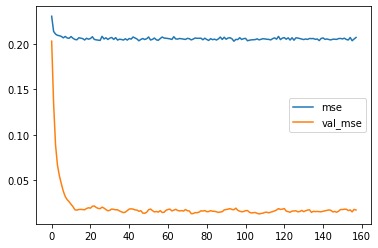

pred_col_name are_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

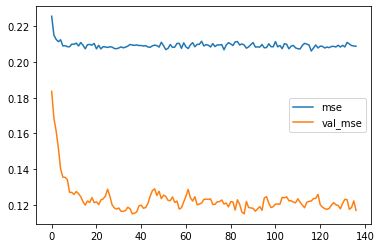

pred_col_name ce_atvi_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

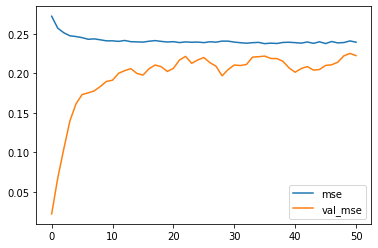

pred_col_name pg_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

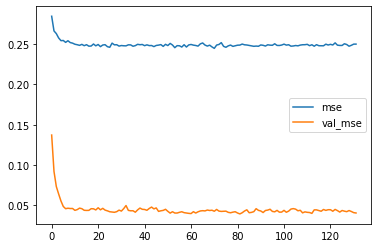

pred_col_name ce_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

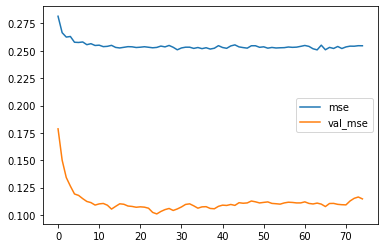

pred_col_name pbj_vfh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

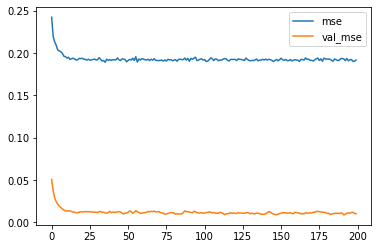

pred_col_name jpm_tjx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

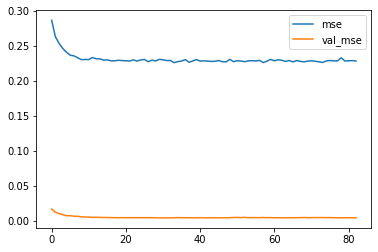

pred_col_name are_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

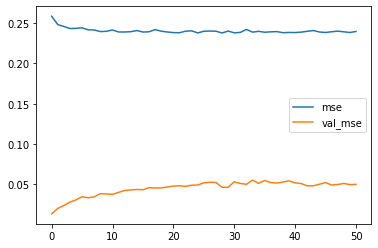

pred_col_name peg_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

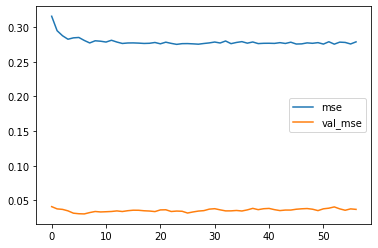

pred_col_name are_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

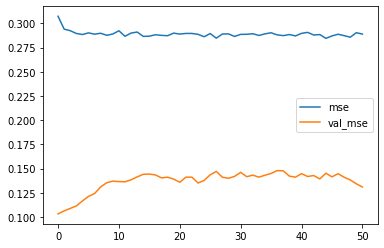

pred_col_name so_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

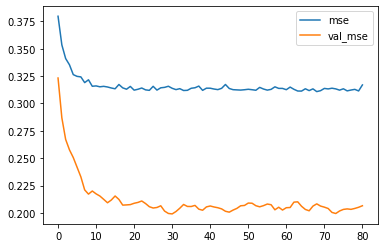

pred_col_name vti_mgm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

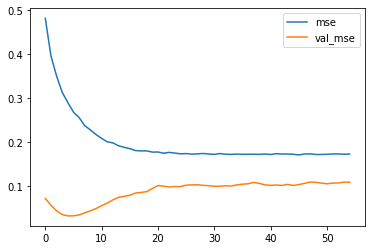

pred_col_name adbe_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

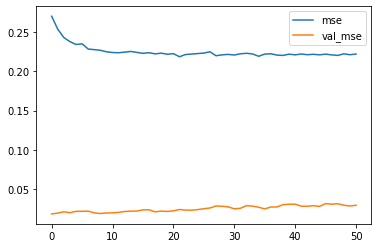

pred_col_name cern_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

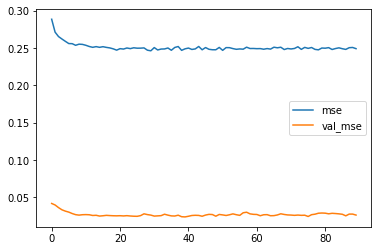

pred_col_name cern_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

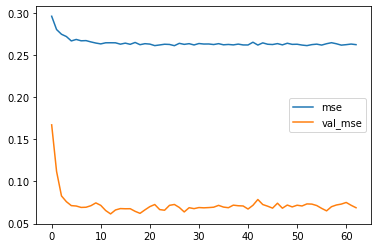

----------
Stock pairing = pg_adbe
Pct finished = 0.23674242424242425
pred_col_name pg_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0

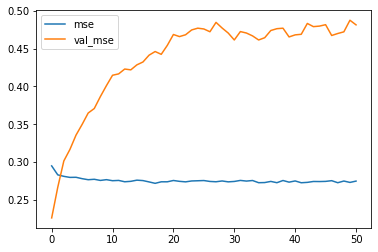

Prediction = 0.30757763981819153
Last corr = 0.807575
pred_col_name emr_iwm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.869867780097425

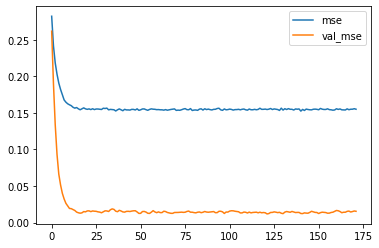

pred_col_name lb_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

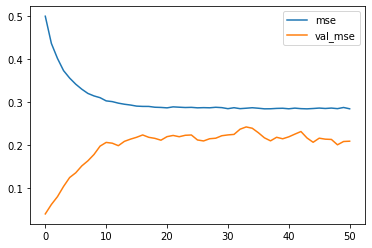

pred_col_name pvh_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

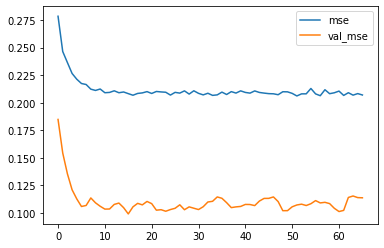

pred_col_name mgm_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

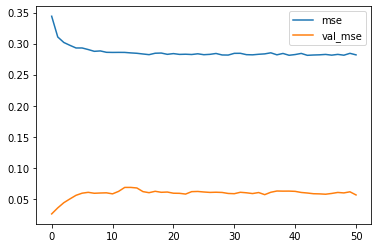

pred_col_name dia_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

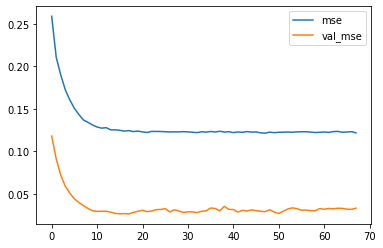

pred_col_name peg_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

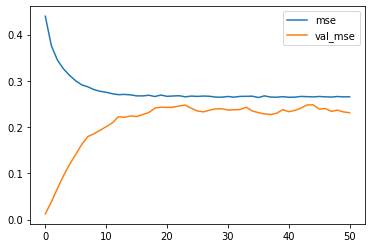

pred_col_name jpm_ce_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

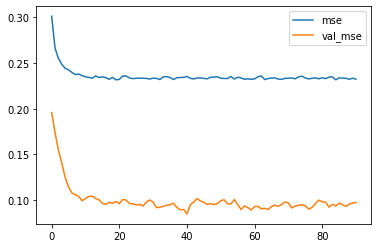

pred_col_name peg_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

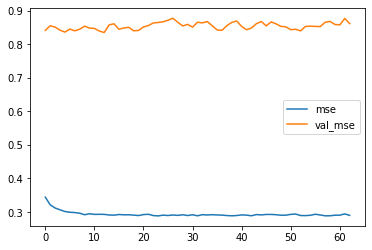

pred_col_name atvi_emr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

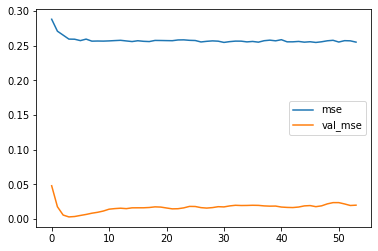

pred_col_name so_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

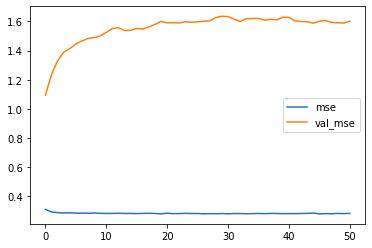

pred_col_name pg_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.939

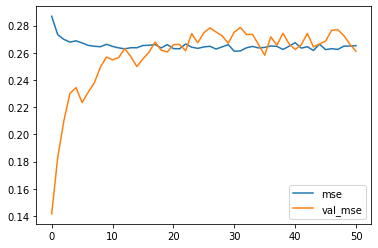

pred_col_name dia_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

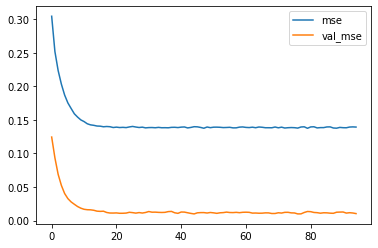

pred_col_name rost_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0

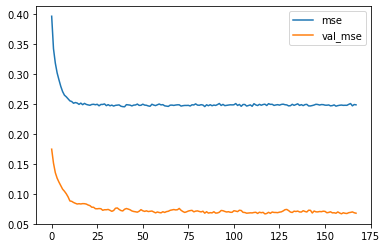

pred_col_name rost_dia_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

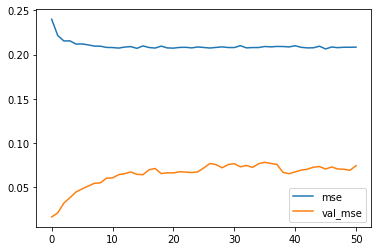

pred_col_name bjk_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

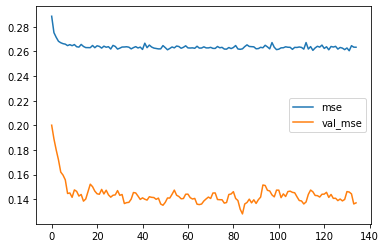

pred_col_name jpm_emr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

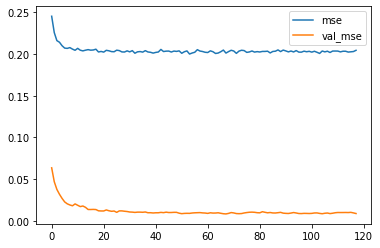

pred_col_name spy_qqq_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

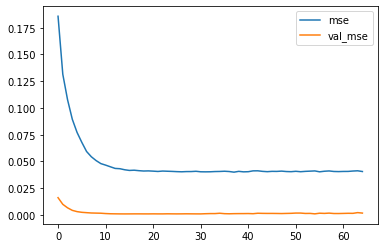

pred_col_name qqq_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

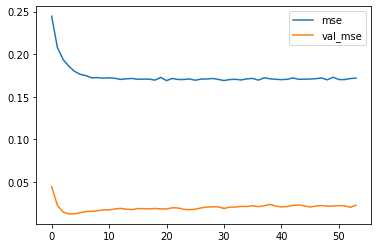

pred_col_name atvi_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

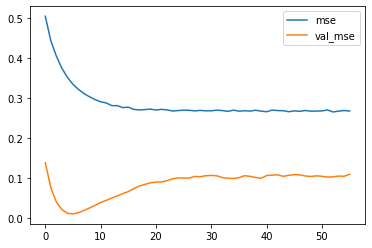

pred_col_name jpm_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

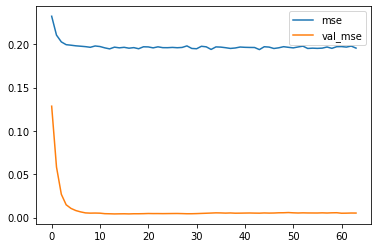

pred_col_name vti_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

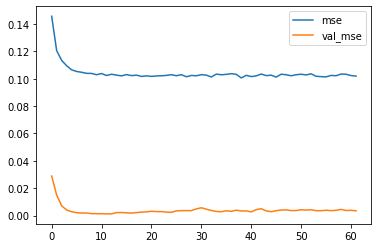

pred_col_name pvh_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

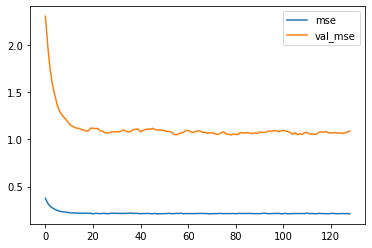

pred_col_name spy_dia_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

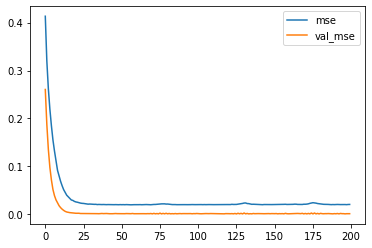

pred_col_name vfh_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

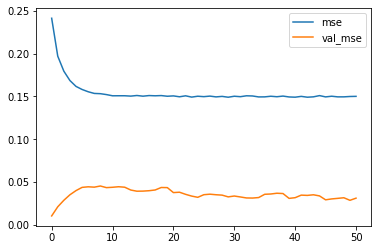

----------
Stock pairing = mgm_iwm
Pct finished = 0.2840909090909091
pred_col_name mgm_iwm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.

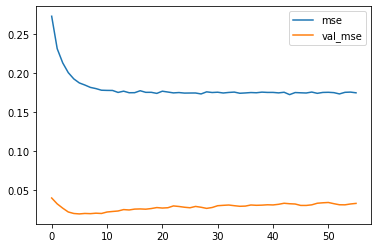

Prediction = 0.7470999956130981
Last corr = 0.601142
pred_col_name so_pvh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252


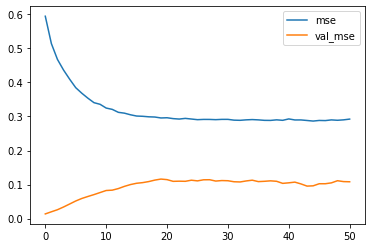

pred_col_name emr_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

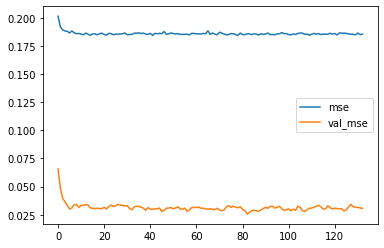

pred_col_name jpm_mgm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

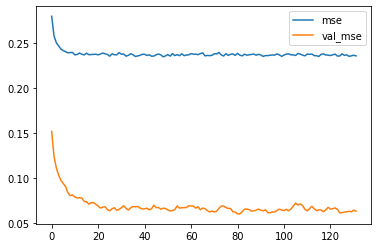

pred_col_name pbj_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

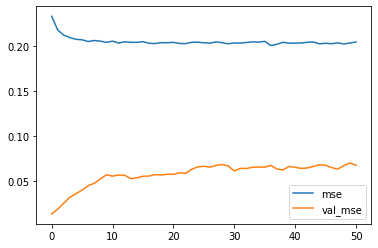

pred_col_name pej_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

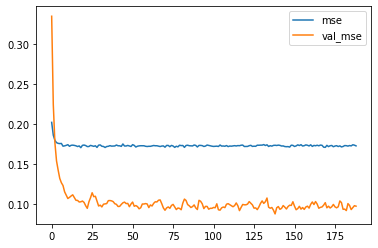

pred_col_name so_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

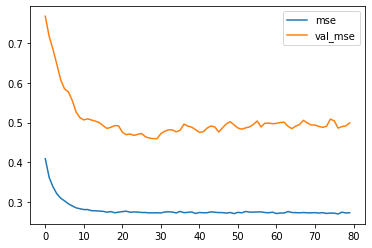

pred_col_name mgm_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

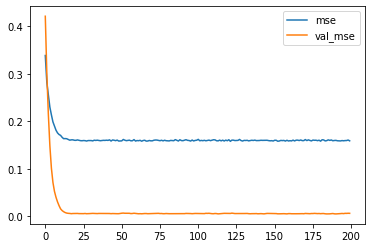

pred_col_name pvh_pg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

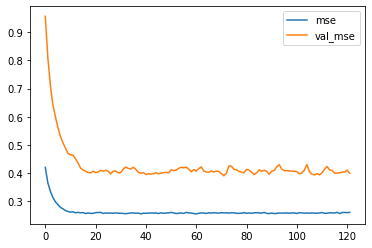

pred_col_name iwm_tjx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

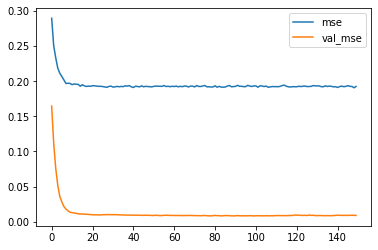

pred_col_name rop_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

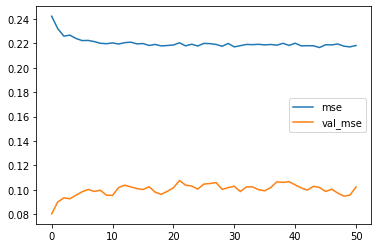

pred_col_name pg_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

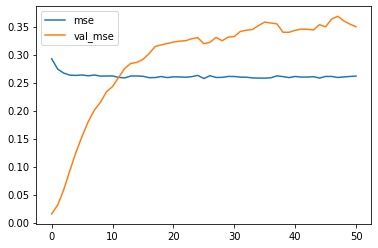

pred_col_name so_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

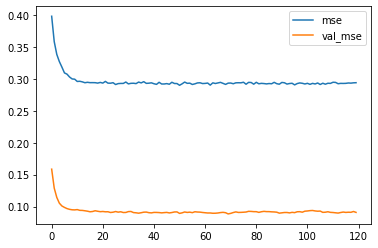

pred_col_name cern_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

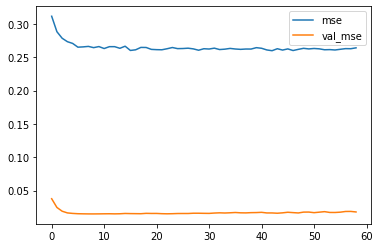

pred_col_name tjx_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

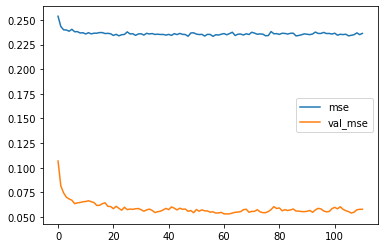

pred_col_name atvi_iwm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

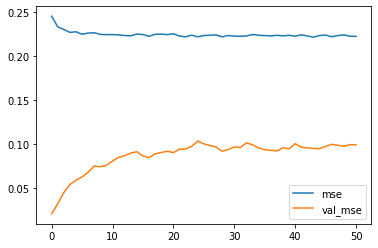

pred_col_name mgm_tjx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

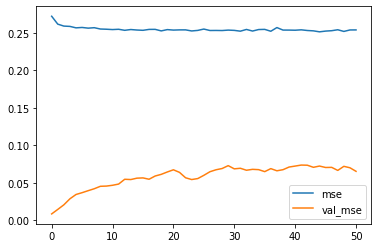

pred_col_name pvh_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

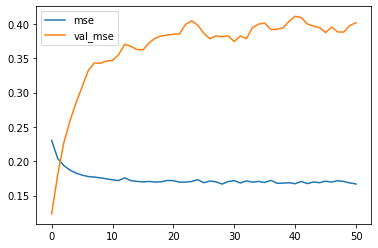

pred_col_name pg_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

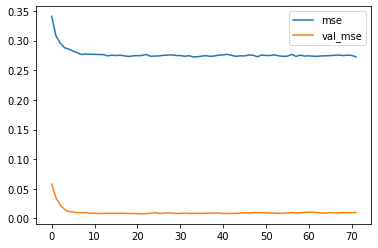

pred_col_name tjx_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

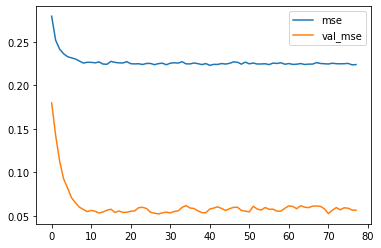

pred_col_name vti_emr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

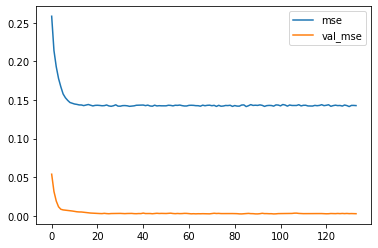

pred_col_name qqq_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

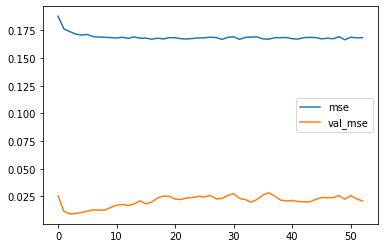

pred_col_name so_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

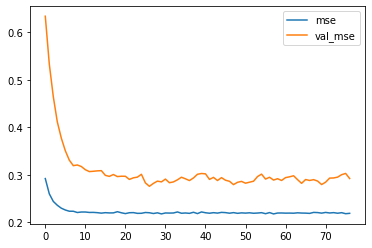

pred_col_name adbe_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0

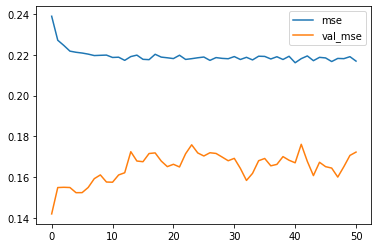

pred_col_name vfh_mgm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

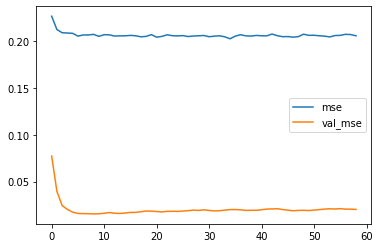

----------
Stock pairing = qqq_xrt
Pct finished = 0.3314393939393939
pred_col_name qqq_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.

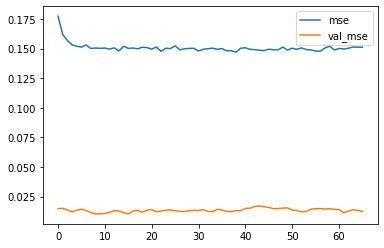

Prediction = 0.7768351435661316
Last corr = 0.91587
pred_col_name vfh_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
P

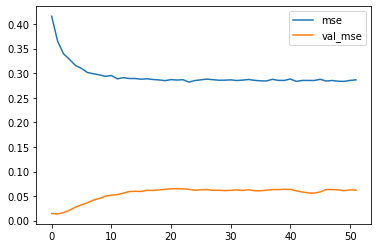

pred_col_name mgm_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

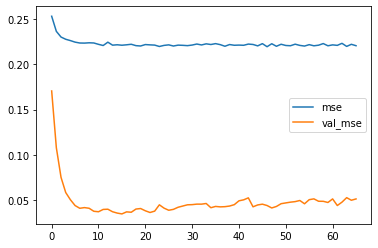

pred_col_name vti_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

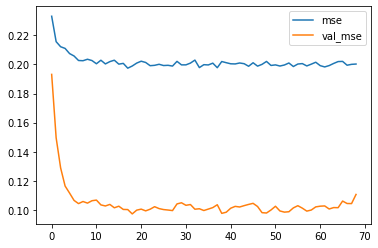

pred_col_name mgm_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

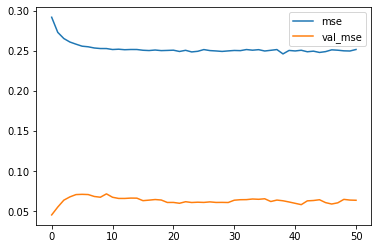

pred_col_name mgm_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

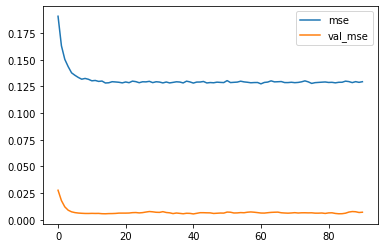

pred_col_name rost_emr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

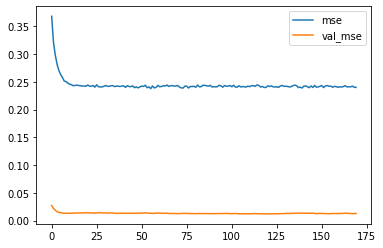

pred_col_name rost_eqix_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0

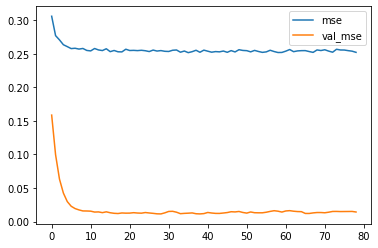

pred_col_name mgm_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

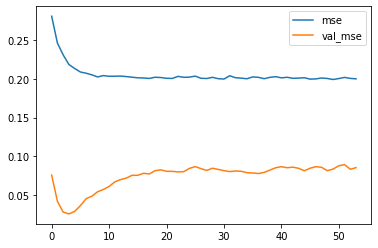

pred_col_name tjx_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

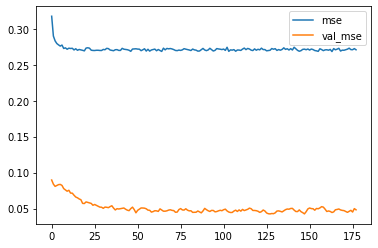

pred_col_name pej_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

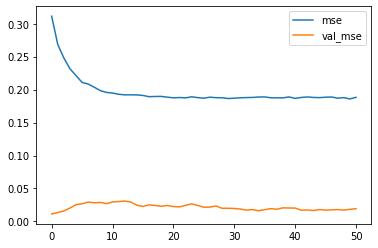

pred_col_name bjk_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

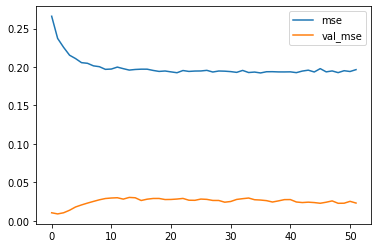

pred_col_name ce_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

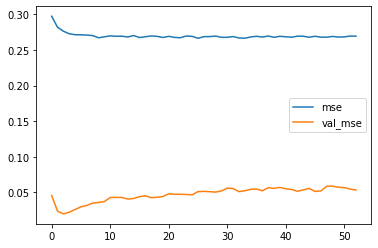

pred_col_name pg_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.939

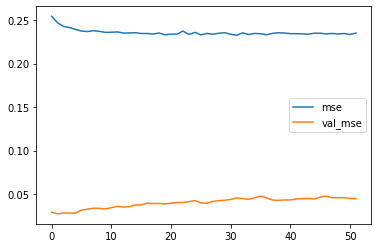

pred_col_name lb_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

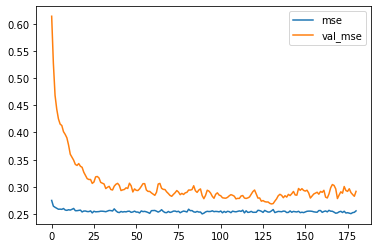

pred_col_name pbj_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

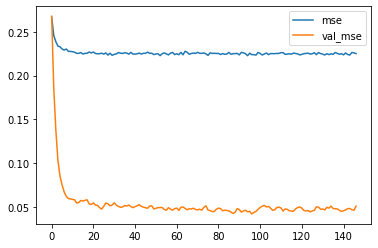

pred_col_name mgm_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

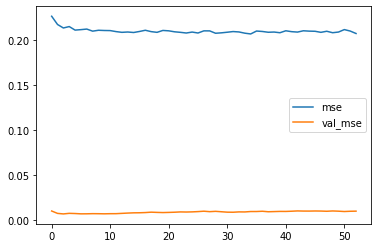

pred_col_name so_mgm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

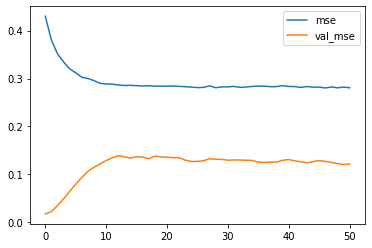

pred_col_name cern_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

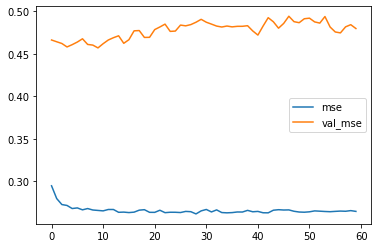

pred_col_name tjx_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

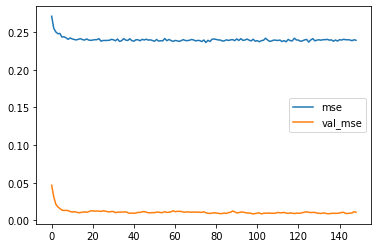

pred_col_name emr_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

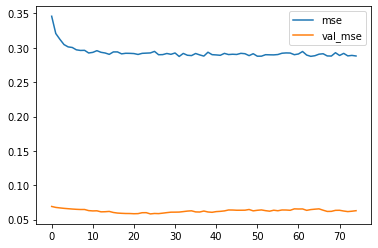

pred_col_name atvi_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

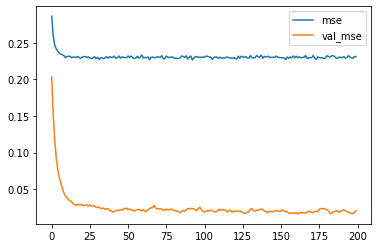

pred_col_name pvh_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

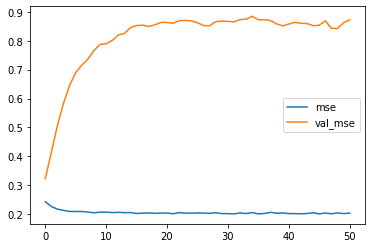

pred_col_name bjk_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

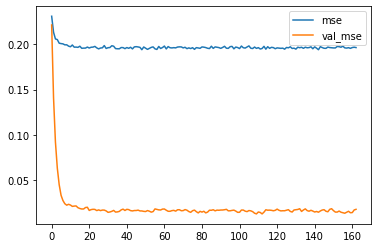

pred_col_name mgm_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

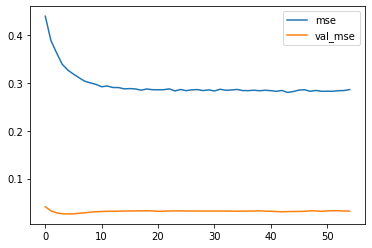

----------
Stock pairing = peg_bac
Pct finished = 0.3787878787878788
pred_col_name peg_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.

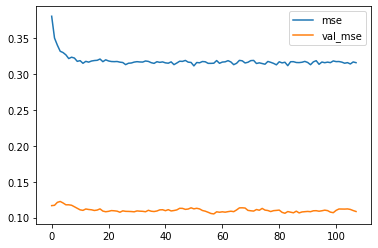

Prediction = 0.3722670078277588
Last corr = 0.140913
pred_col_name lb_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252


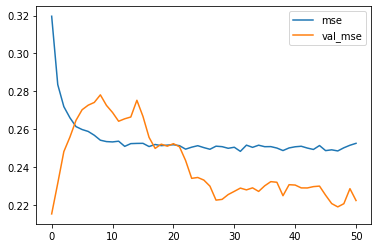

pred_col_name so_iwm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

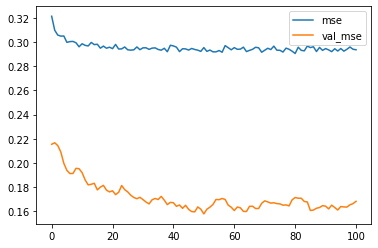

pred_col_name ph_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

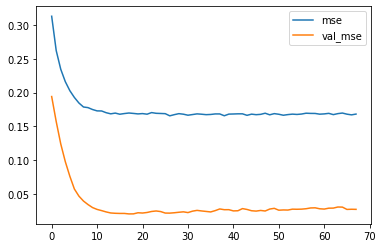

pred_col_name vti_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

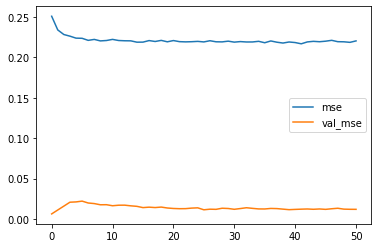

pred_col_name emr_pg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

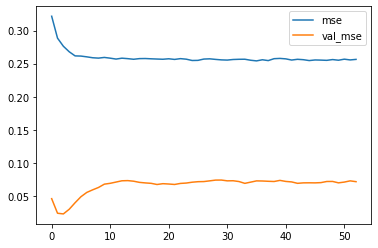

pred_col_name qqq_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

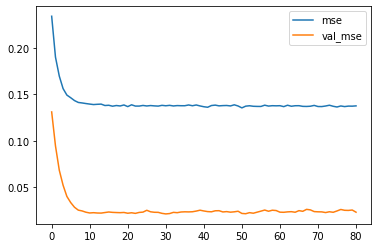

pred_col_name pnr_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

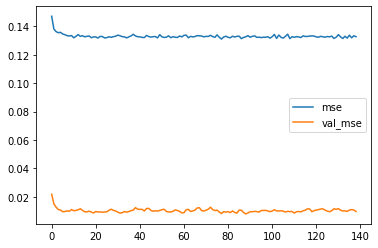

pred_col_name pbj_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

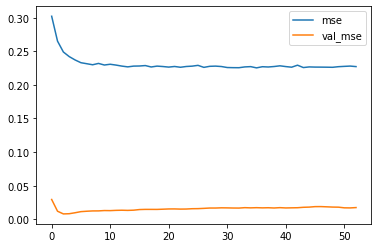

pred_col_name ni_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.939

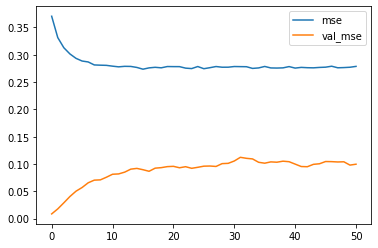

pred_col_name are_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

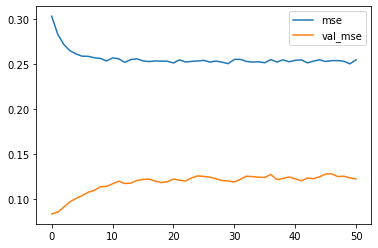

pred_col_name qqq_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

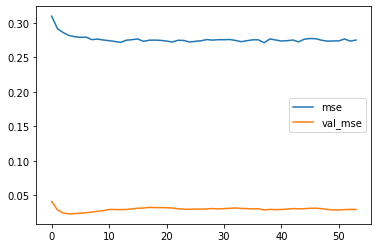

pred_col_name eqix_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

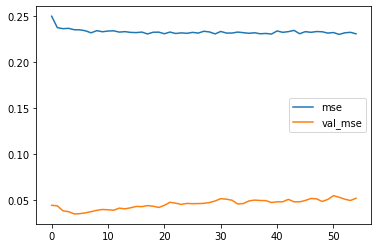

pred_col_name pej_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

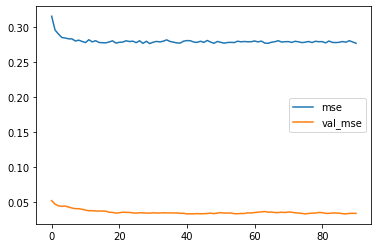

pred_col_name lb_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

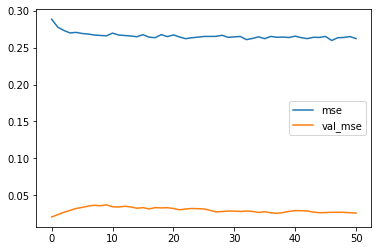

pred_col_name emr_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

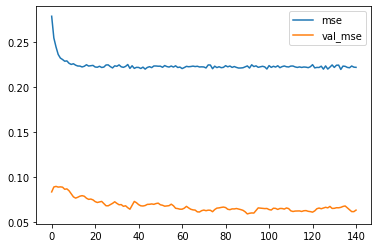

pred_col_name vfh_pvh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

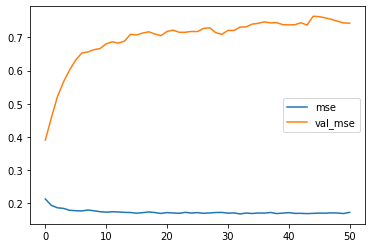

pred_col_name pg_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

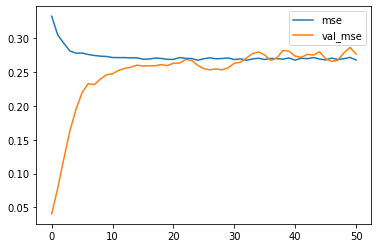

pred_col_name jpm_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

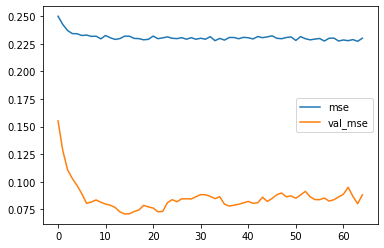

pred_col_name jpm_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

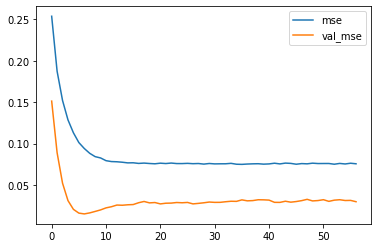

pred_col_name vfh_jpm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

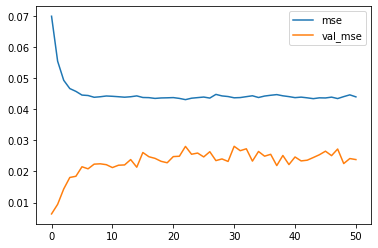

pred_col_name dia_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

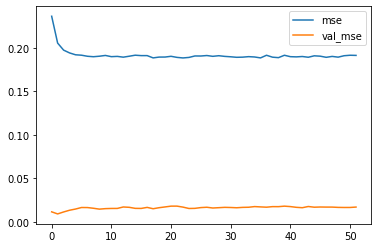

pred_col_name rost_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

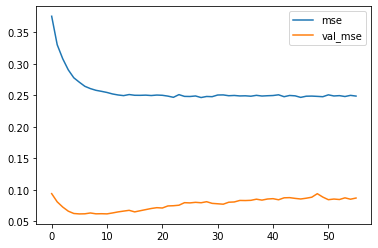

pred_col_name tjx_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

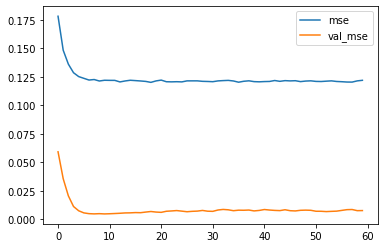

pred_col_name pbj_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

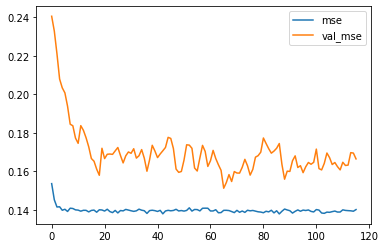

----------
Stock pairing = emr_bac
Pct finished = 0.42613636363636365
pred_col_name emr_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0

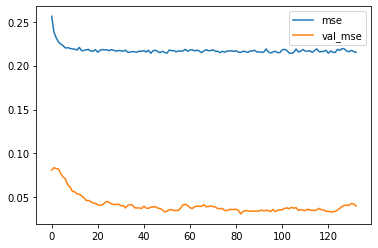

Prediction = 0.7411874532699585
Last corr = 0.898076
pred_col_name lb_tjx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252


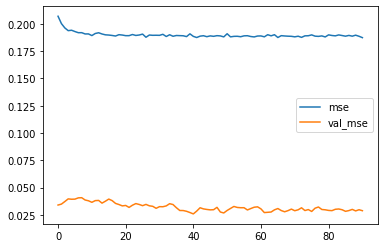

pred_col_name atvi_pvh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

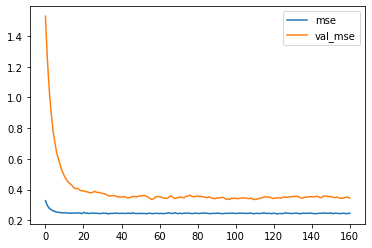

pred_col_name jpm_pg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

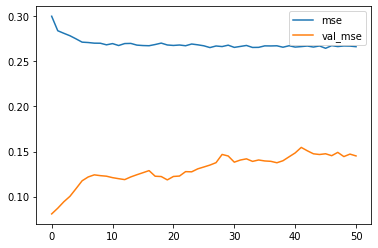

pred_col_name spy_pbj_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

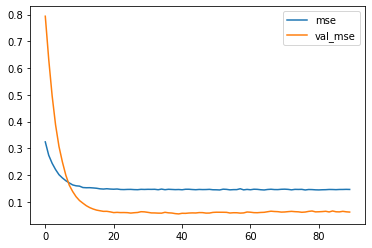

pred_col_name tjx_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

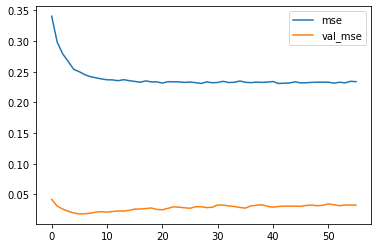

pred_col_name lb_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

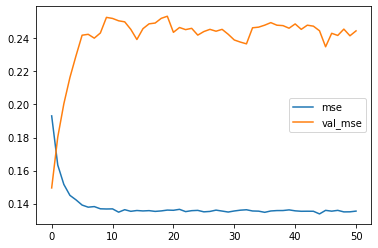

pred_col_name spy_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

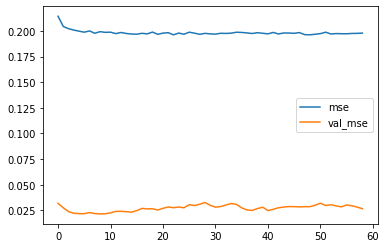

pred_col_name adbe_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

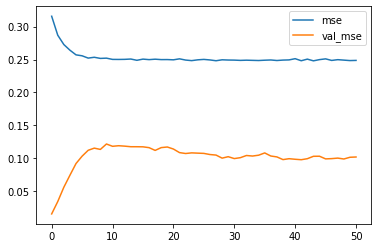

pred_col_name vfh_tjx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

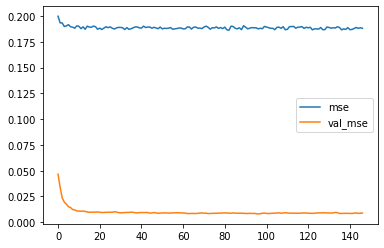

pred_col_name mgm_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

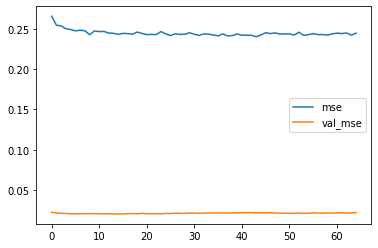

pred_col_name eqix_dia_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

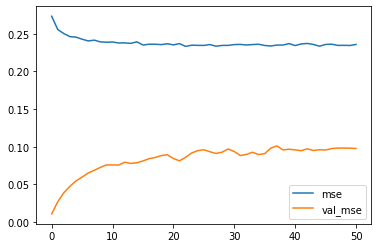

pred_col_name vti_jpm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

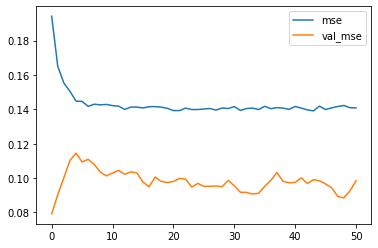

pred_col_name qqq_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

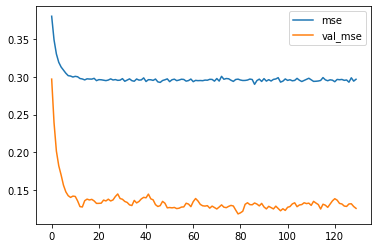

pred_col_name pg_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

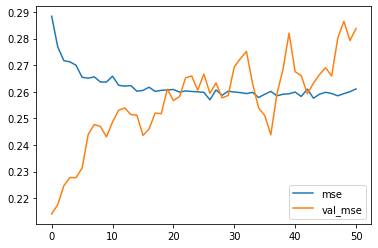

pred_col_name vti_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

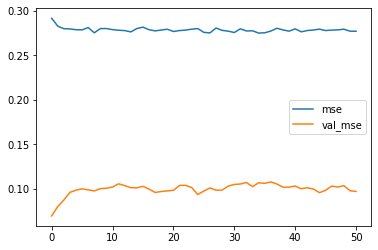

pred_col_name rost_vti_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

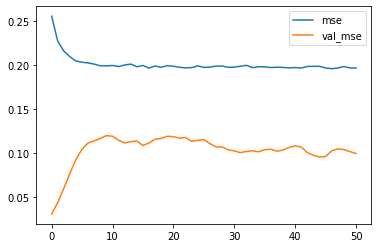

pred_col_name qqq_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

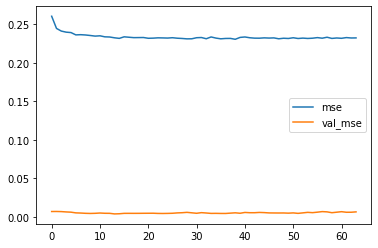

pred_col_name emr_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

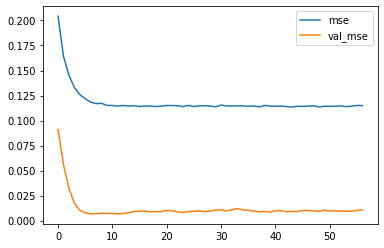

pred_col_name tjx_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

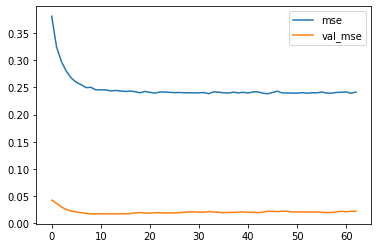

pred_col_name eqix_jpm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

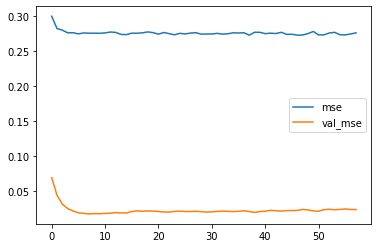

pred_col_name atvi_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

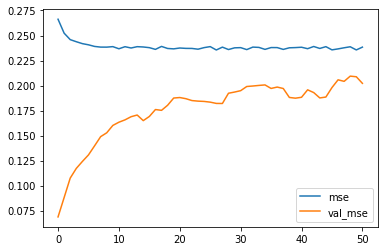

pred_col_name atvi_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

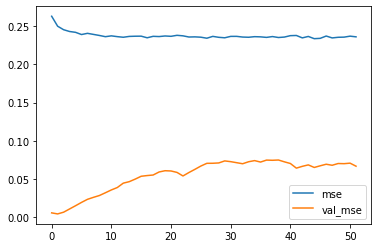

pred_col_name rost_jpm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

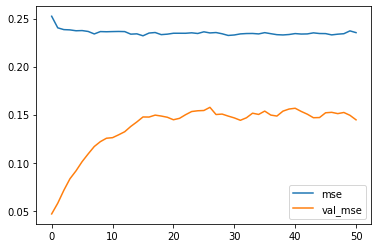

pred_col_name bac_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

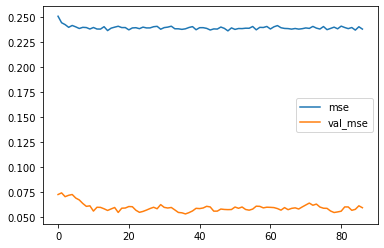

----------
Stock pairing = peg_ual
Pct finished = 0.4734848484848485
pred_col_name peg_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.

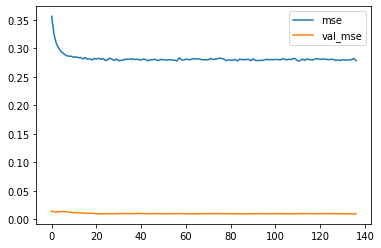

Prediction = 0.36997541785240173
Last corr = 0.377183
pred_col_name atvi_mgm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.86986778009742

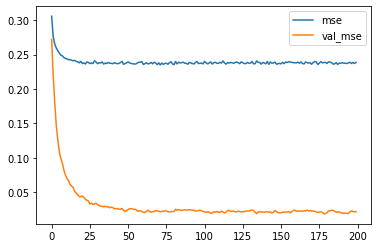

pred_col_name ual_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

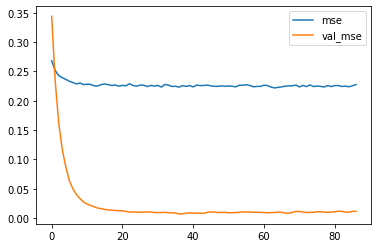

pred_col_name ph_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

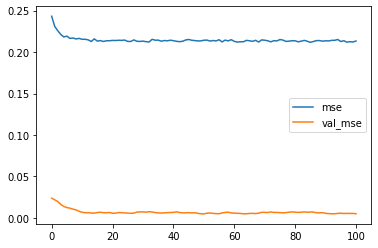

pred_col_name vfh_dia_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

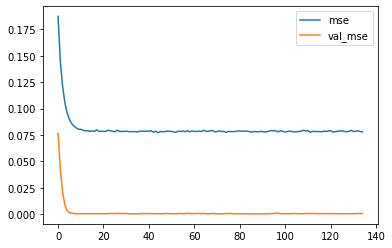

pred_col_name rop_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

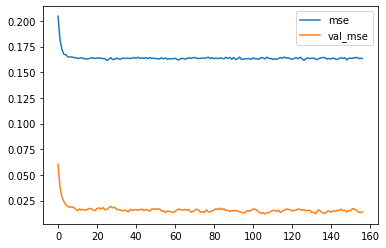

pred_col_name ni_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

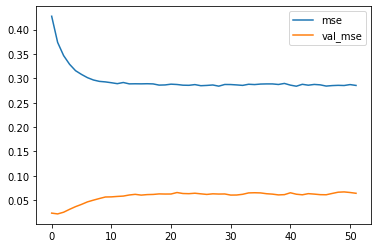

pred_col_name pbj_lb_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

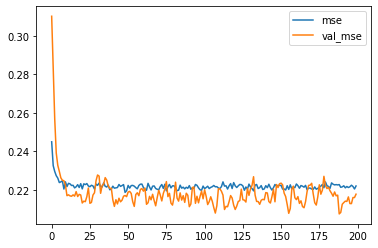

pred_col_name cern_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

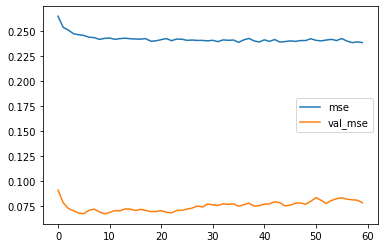

pred_col_name vfh_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

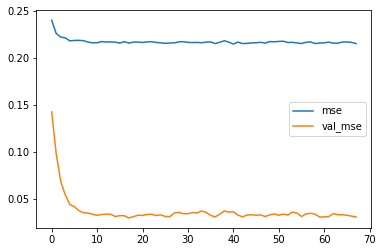

pred_col_name pg_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

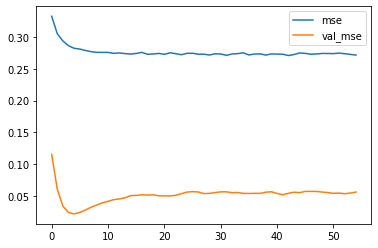

pred_col_name eqix_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

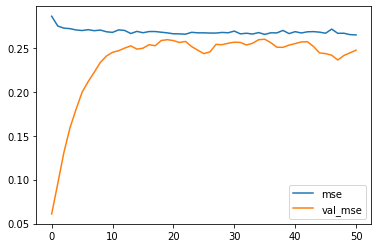

pred_col_name rost_pg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

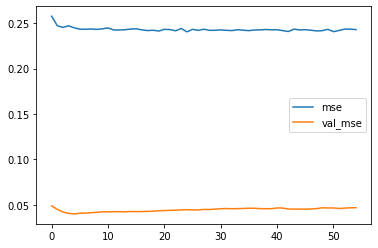

pred_col_name spy_pg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

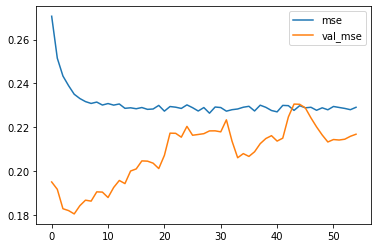

pred_col_name pg_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

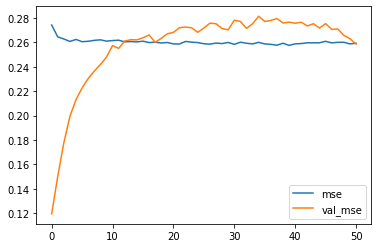

pred_col_name vfh_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

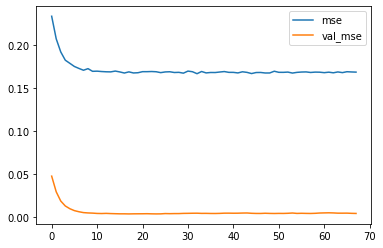

pred_col_name spy_vti_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

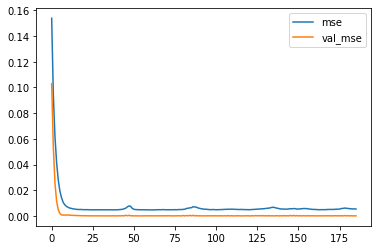

pred_col_name spy_ce_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

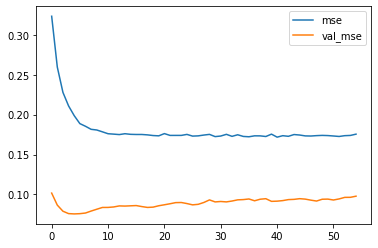

pred_col_name pvh_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

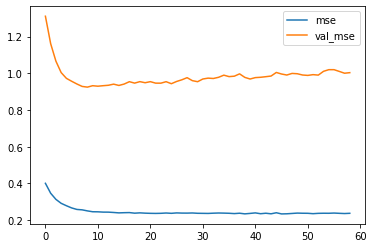

pred_col_name ce_mgm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

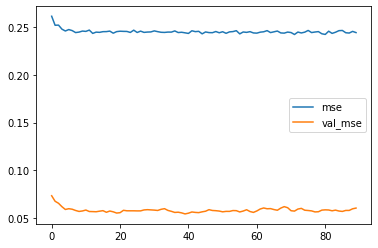

pred_col_name eqix_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

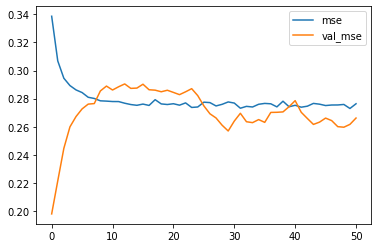

pred_col_name pbj_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

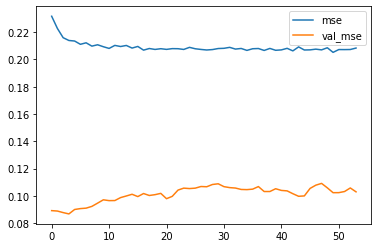

pred_col_name pnr_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

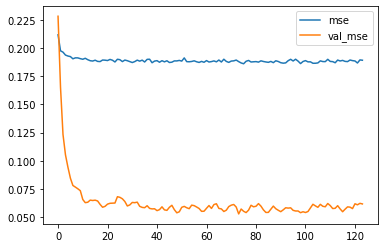

pred_col_name emr_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

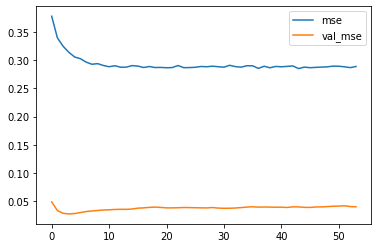

pred_col_name rop_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

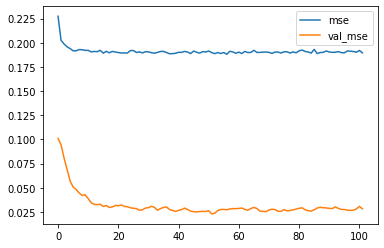

----------
Stock pairing = spy_pnr
Pct finished = 0.5208333333333334
pred_col_name spy_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.

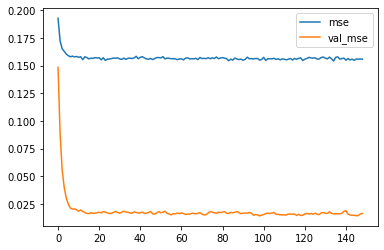

Prediction = 0.900251567363739
Last corr = 0.92673
pred_col_name bac_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
P

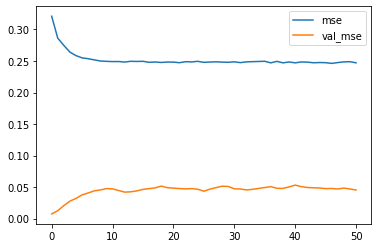

pred_col_name jpm_iwm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

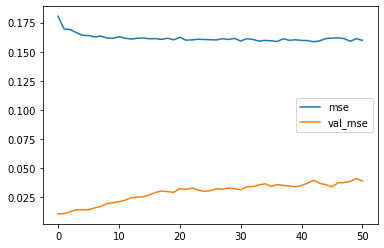

pred_col_name spy_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

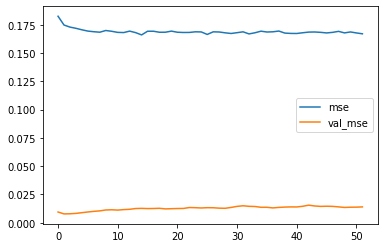

pred_col_name jpm_dia_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

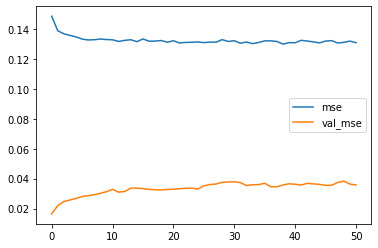

pred_col_name pbj_ce_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

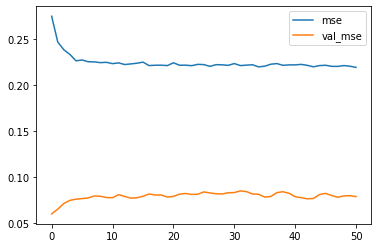

pred_col_name rost_qqq_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

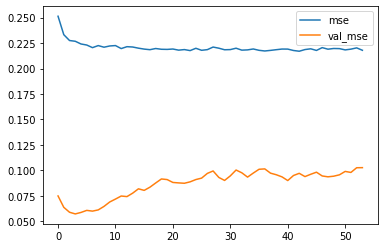

pred_col_name peg_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

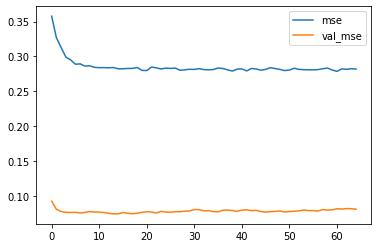

pred_col_name adbe_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

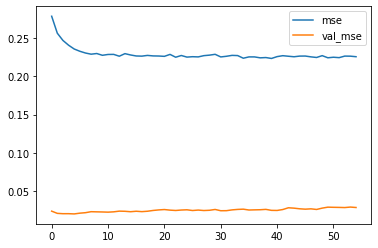

pred_col_name so_emr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

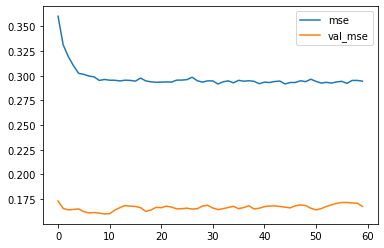

pred_col_name rost_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

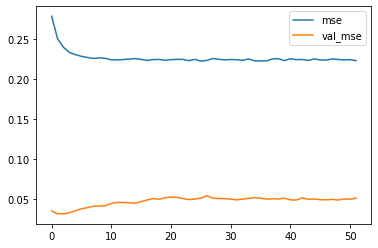

pred_col_name iwm_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

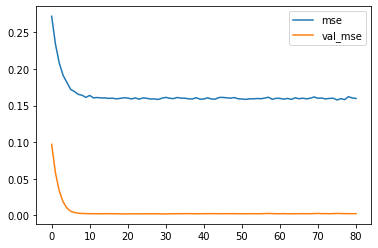

pred_col_name pej_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

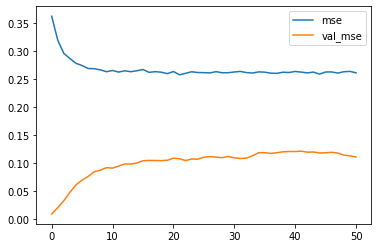

pred_col_name so_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

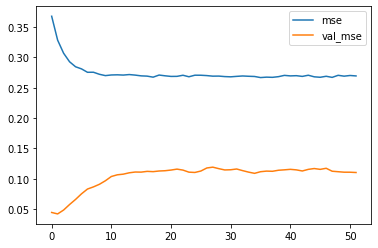

pred_col_name rop_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

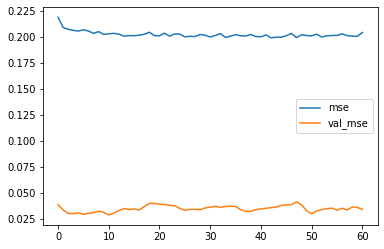

pred_col_name so_pg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.939

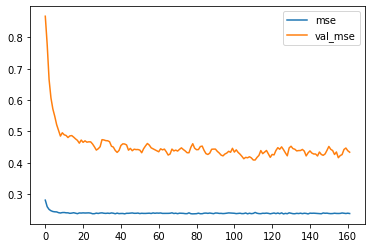

pred_col_name lb_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

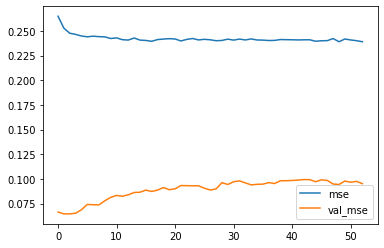

pred_col_name qqq_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

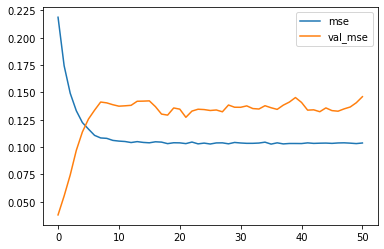

pred_col_name pbj_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

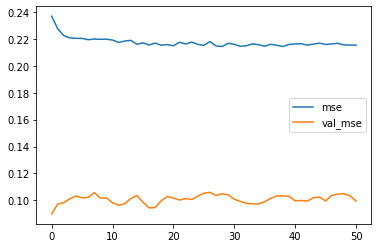

pred_col_name adbe_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

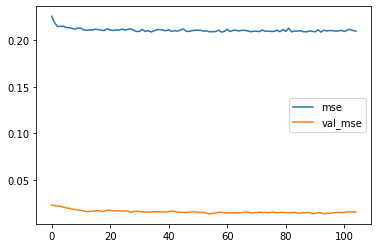

pred_col_name qqq_jpm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

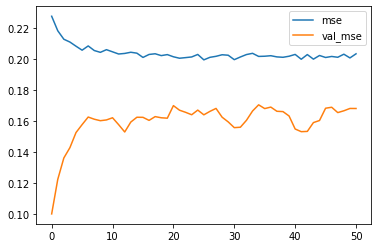

pred_col_name rost_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

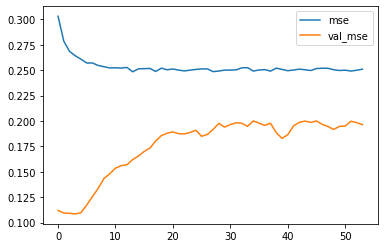

pred_col_name pg_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

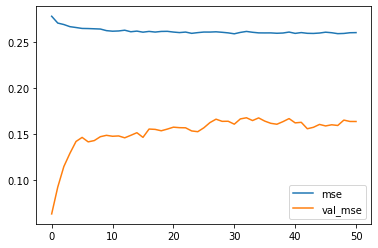

pred_col_name vti_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

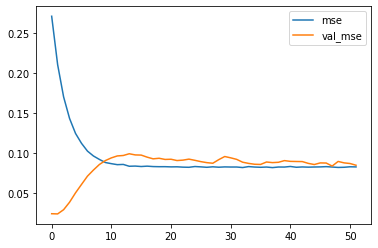

pred_col_name vti_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

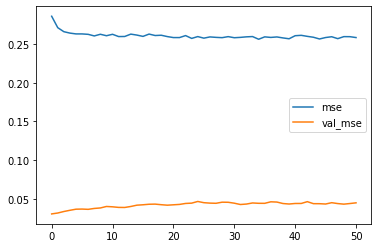

----------
Stock pairing = jpm_are
Pct finished = 0.5681818181818182
pred_col_name jpm_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.

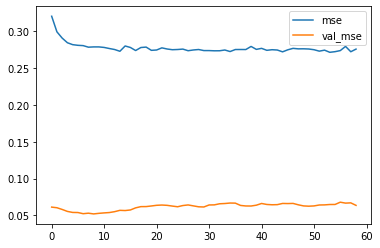

Prediction = 0.5568252801895142
Last corr = 0.47885
pred_col_name rost_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252

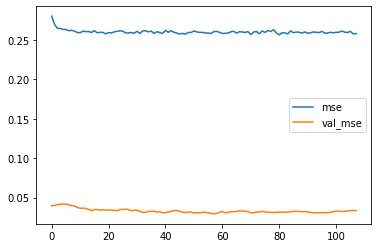

pred_col_name iwm_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

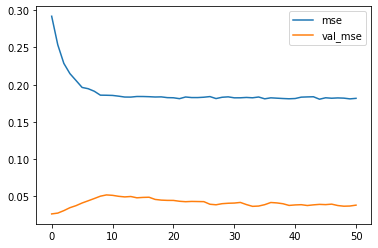

pred_col_name vti_lb_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

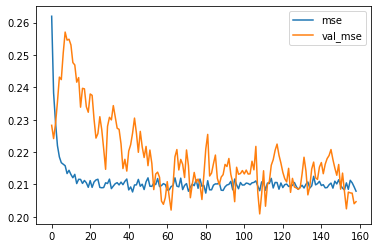

pred_col_name mgm_pvh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

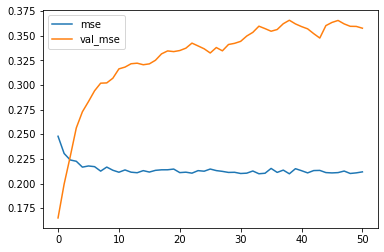

pred_col_name atvi_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

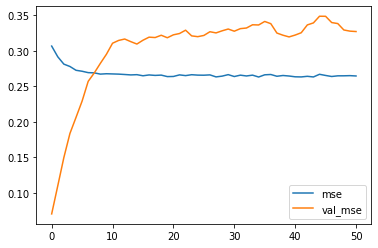

pred_col_name are_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

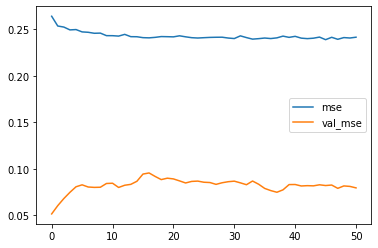

pred_col_name pbj_atvi_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

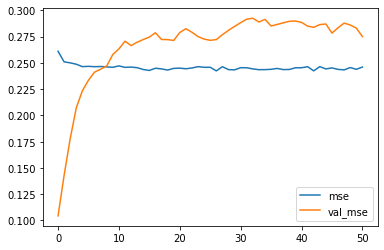

pred_col_name jpm_pvh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

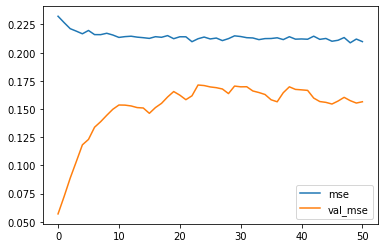

pred_col_name vfh_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

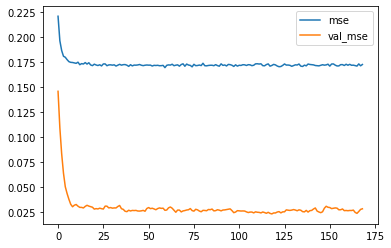

pred_col_name atvi_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

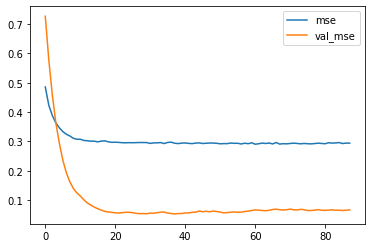

pred_col_name cern_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

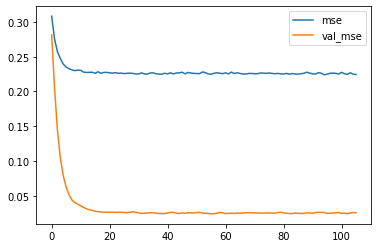

pred_col_name rop_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

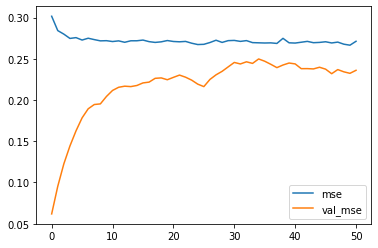

pred_col_name qqq_vfh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

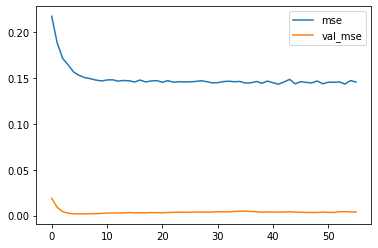

pred_col_name pej_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

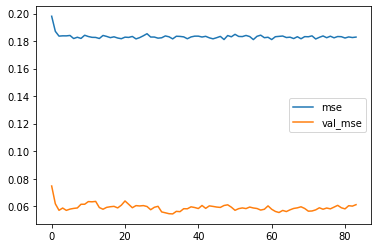

pred_col_name vfh_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

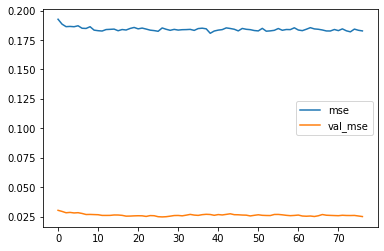

pred_col_name qqq_ce_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

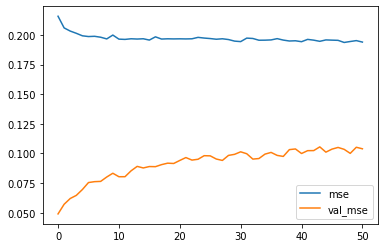

pred_col_name so_qqq_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

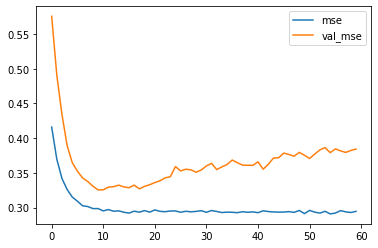

pred_col_name so_jpm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

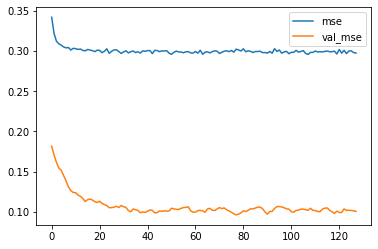

pred_col_name ni_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

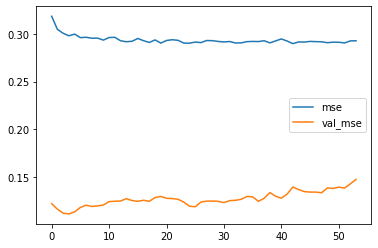

pred_col_name tjx_dia_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

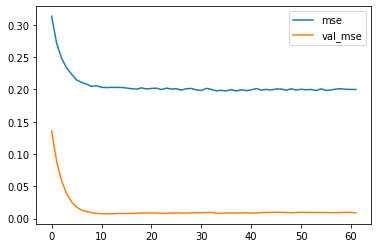

pred_col_name pbj_tjx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

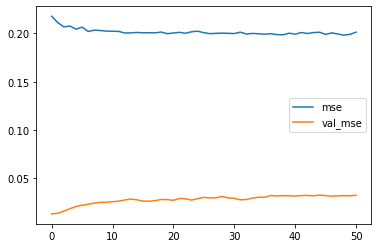

pred_col_name spy_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

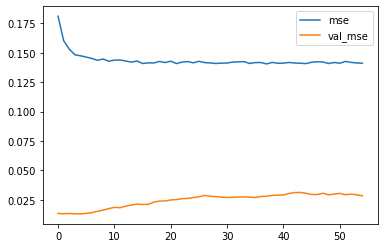

pred_col_name qqq_iwm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

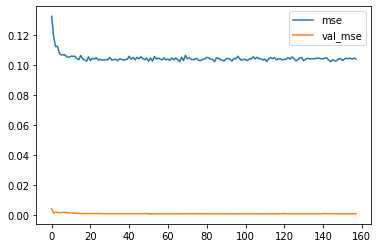

pred_col_name atvi_pg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

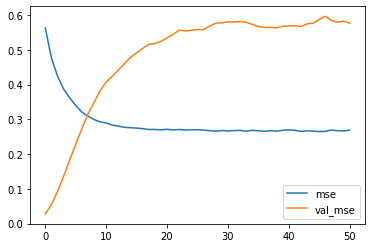

----------
Stock pairing = eqix_pej
Pct finished = 0.615530303030303
pred_col_name eqix_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0

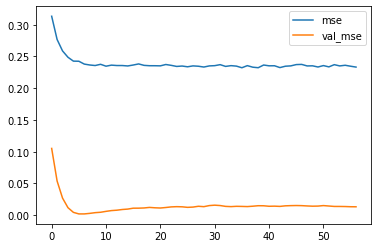

Prediction = 0.2679518461227417
Last corr = 0.336734
pred_col_name vfh_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252

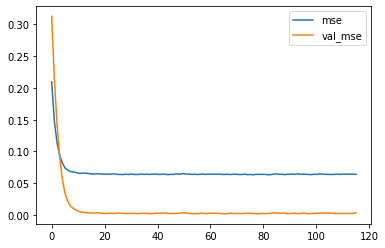

pred_col_name jpm_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

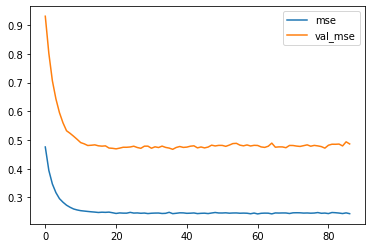

pred_col_name ce_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

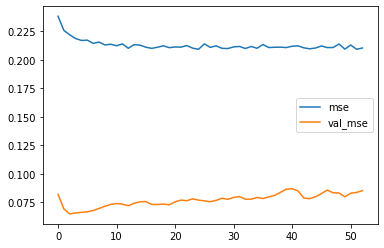

pred_col_name ph_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

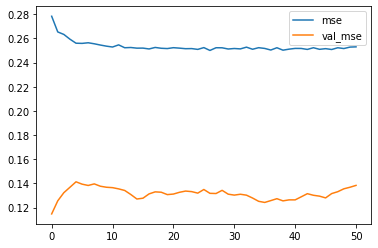

pred_col_name vti_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

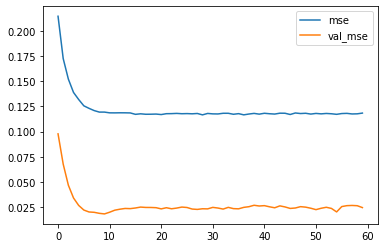

pred_col_name qqq_atvi_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

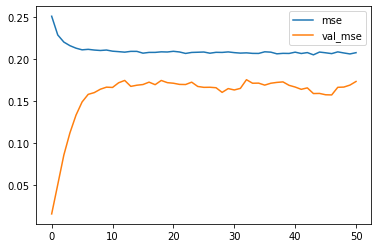

pred_col_name qqq_lb_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

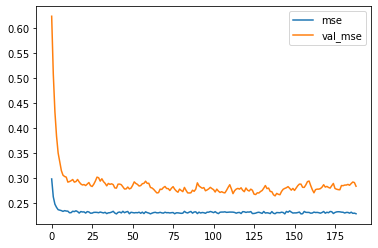

pred_col_name ce_dia_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

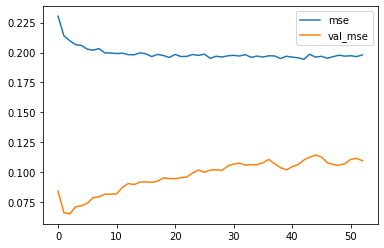

pred_col_name dia_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

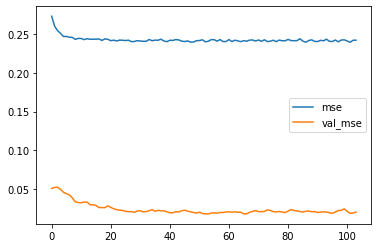

pred_col_name spy_tjx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

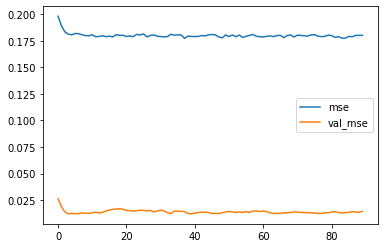

pred_col_name atvi_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

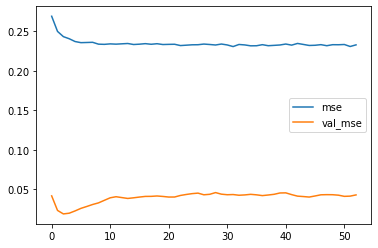

pred_col_name dia_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

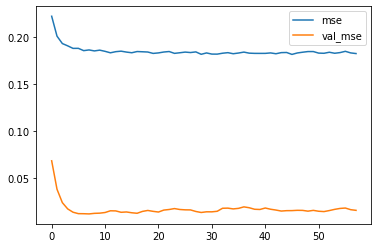

pred_col_name jpm_lb_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

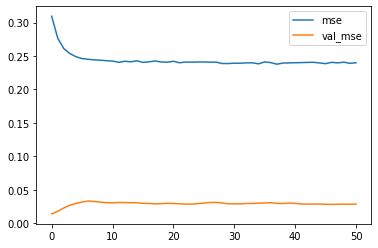

pred_col_name qqq_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

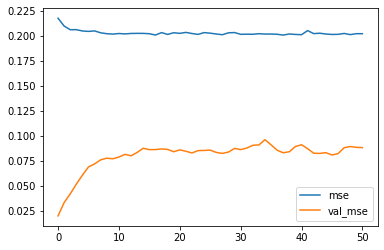

pred_col_name atvi_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

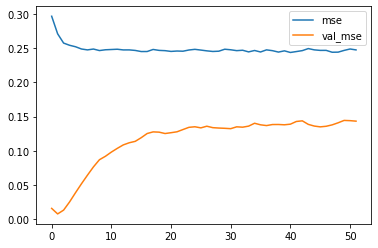

pred_col_name peg_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

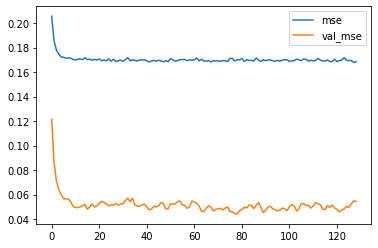

pred_col_name atvi_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0

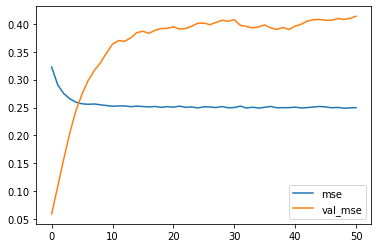

pred_col_name pbj_pg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

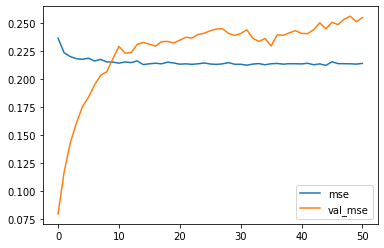

pred_col_name jpm_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

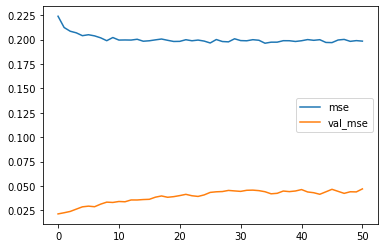

pred_col_name rost_mgm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

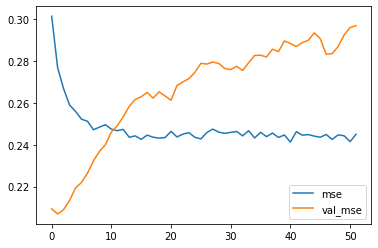

pred_col_name eqix_lb_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

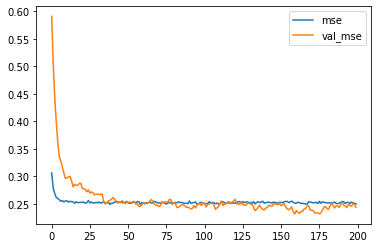

pred_col_name dia_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

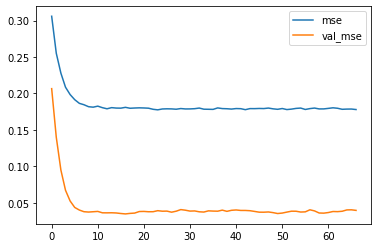

pred_col_name mgm_pg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

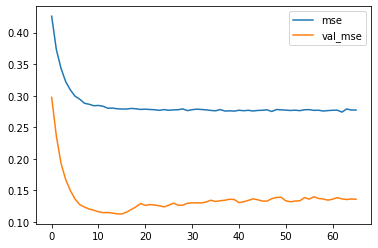

pred_col_name bac_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

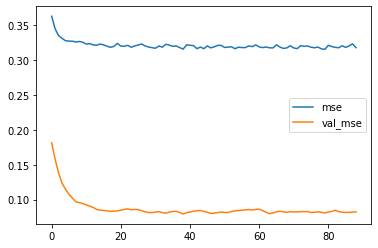

----------
Stock pairing = rost_adbe
Pct finished = 0.6628787878787878
pred_col_name rost_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished 

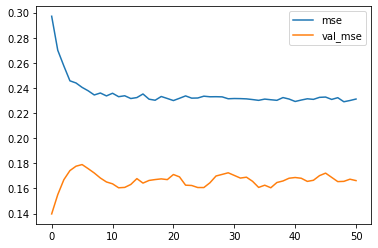

Prediction = 0.2994011342525482
Last corr = 0.033395
pred_col_name emr_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.869867780097425

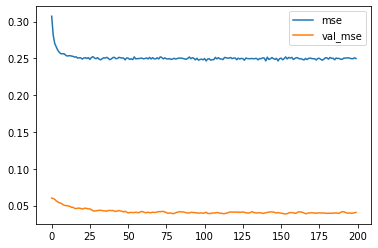

pred_col_name qqq_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

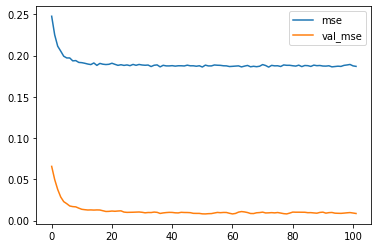

pred_col_name are_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

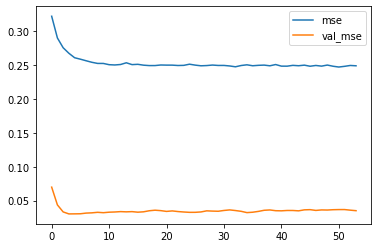

pred_col_name so_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

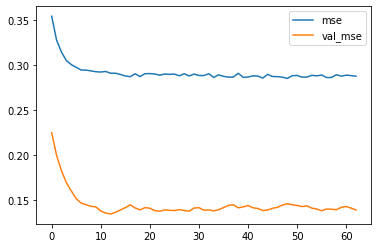

pred_col_name qqq_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

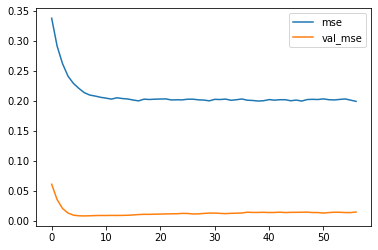

pred_col_name pvh_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

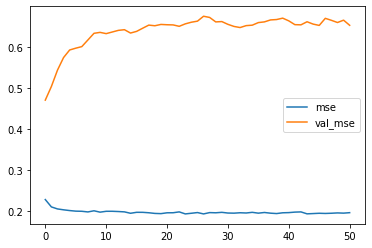

pred_col_name eqix_tjx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

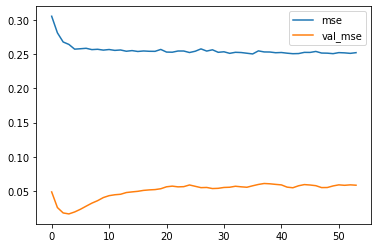

pred_col_name adbe_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

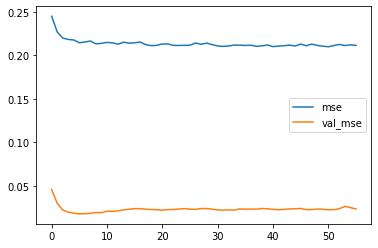

pred_col_name ce_pg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.939

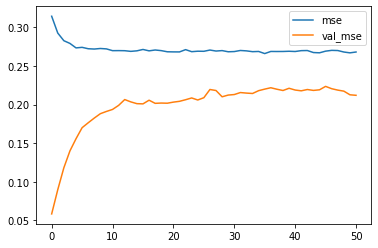

pred_col_name vti_pg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

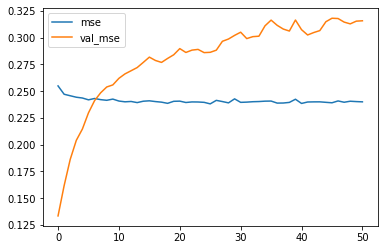

pred_col_name pbj_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

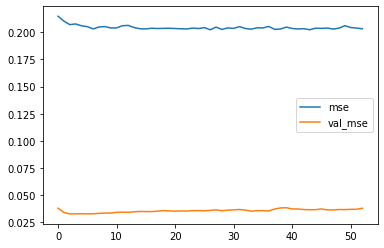

pred_col_name pg_dia_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

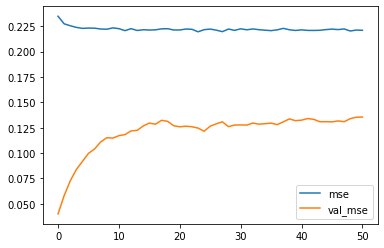

pred_col_name eqix_atvi_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0

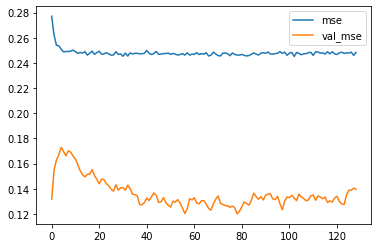

pred_col_name rost_spy_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

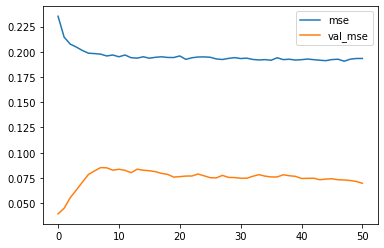

pred_col_name iwm_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

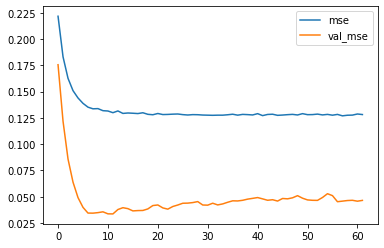

pred_col_name rost_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

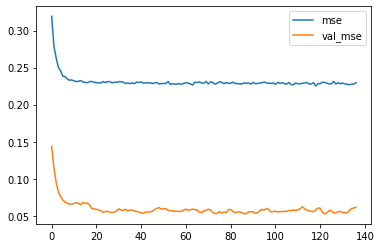

pred_col_name spy_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

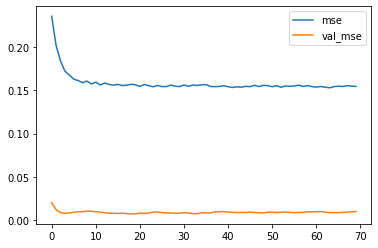

pred_col_name dia_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

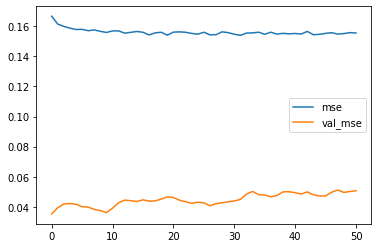

pred_col_name atvi_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

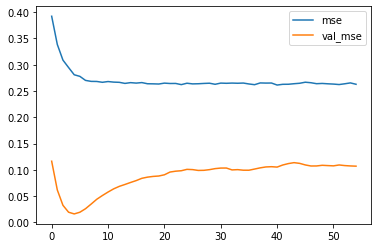

pred_col_name vfh_ce_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

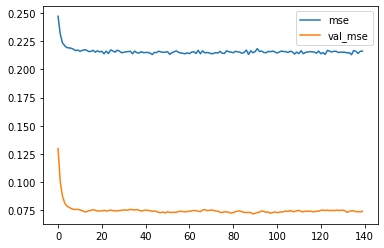

pred_col_name atvi_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

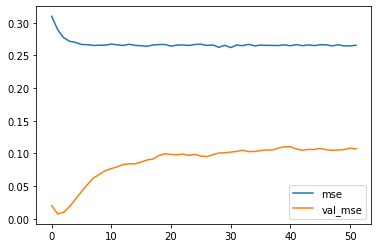

pred_col_name lb_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

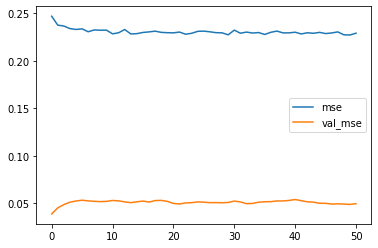

pred_col_name tjx_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

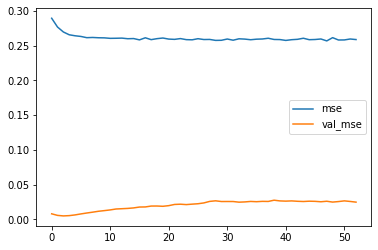

pred_col_name pvh_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

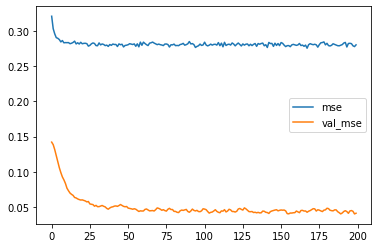

----------
Stock pairing = vti_iwm
Pct finished = 0.7102272727272727
pred_col_name vti_iwm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.

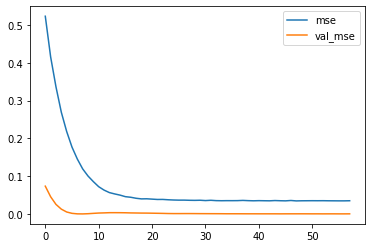

Prediction = 0.9631659388542175
Last corr = 0.95969
pred_col_name tjx_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
P

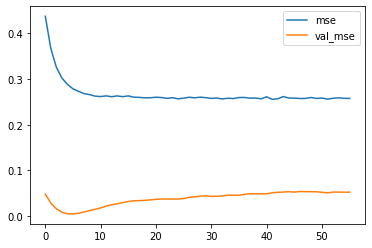

pred_col_name atvi_adbe_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0

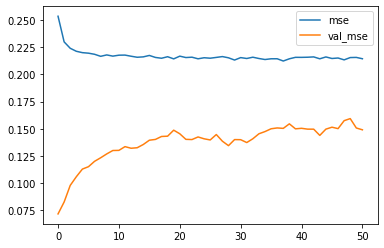

pred_col_name pnr_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

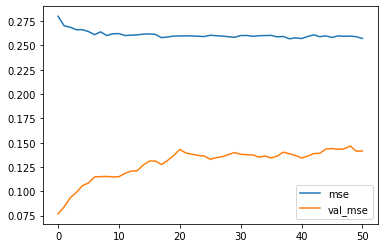

pred_col_name spy_eqix_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

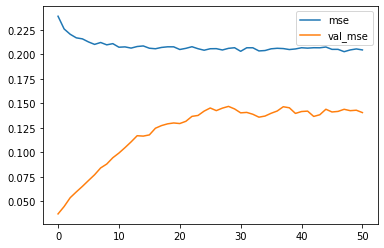

pred_col_name spy_emr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

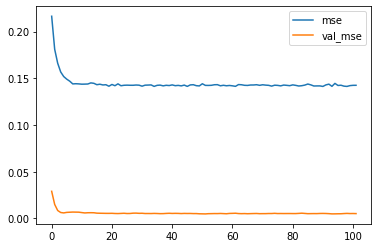

pred_col_name iwm_dia_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

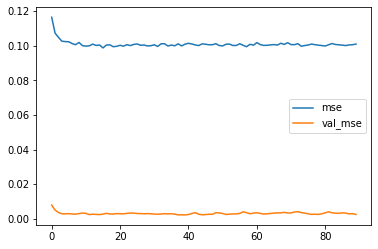

pred_col_name mgm_lb_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

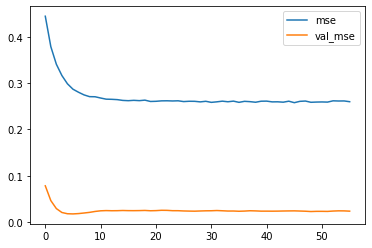

pred_col_name spy_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

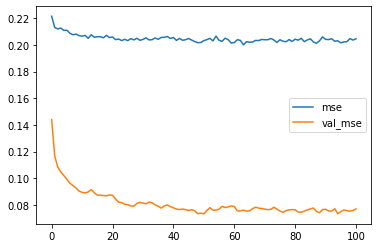

pred_col_name qqq_dia_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

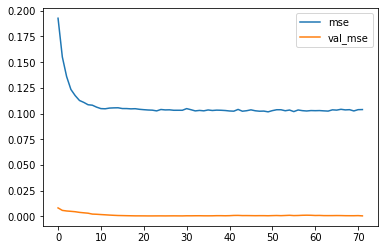

pred_col_name adbe_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

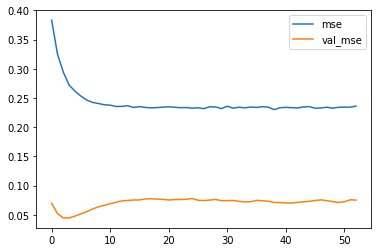

pred_col_name emr_tjx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

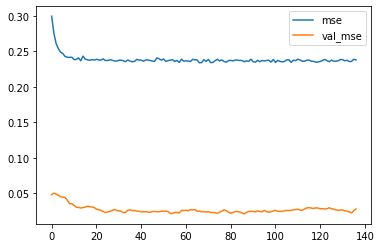

pred_col_name eqix_pvh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

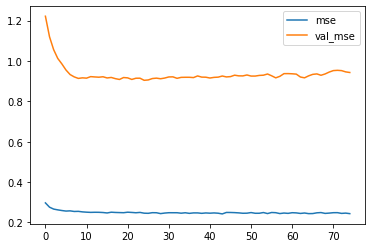

pred_col_name pbj_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

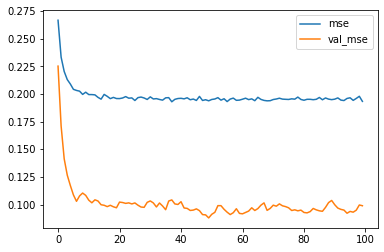

pred_col_name peg_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

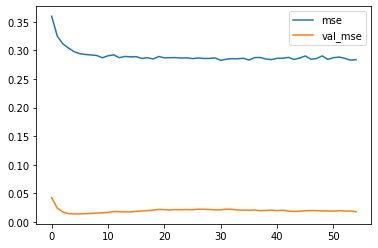

pred_col_name spy_mgm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

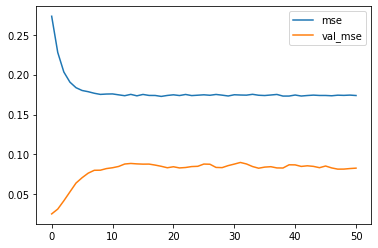

pred_col_name pvh_dia_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

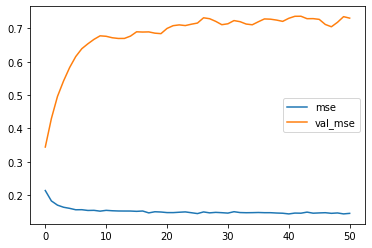

pred_col_name emr_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

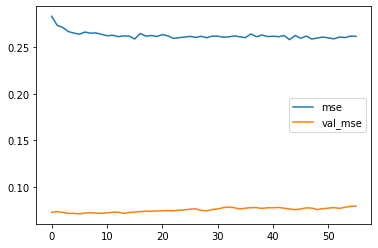

pred_col_name iwm_pg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

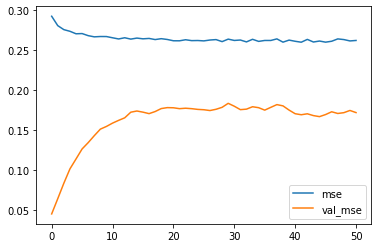

pred_col_name jpm_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

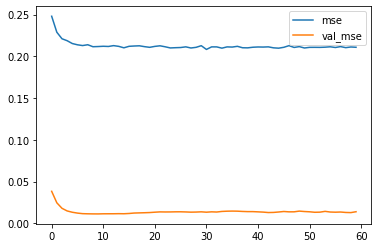

pred_col_name pej_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

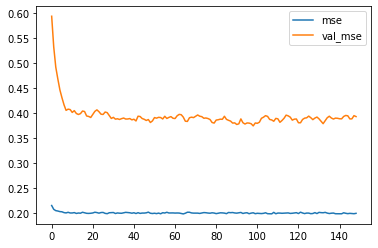

pred_col_name rost_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

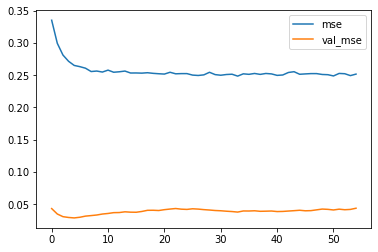

pred_col_name vti_dia_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

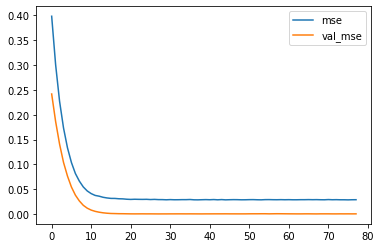

pred_col_name pvh_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

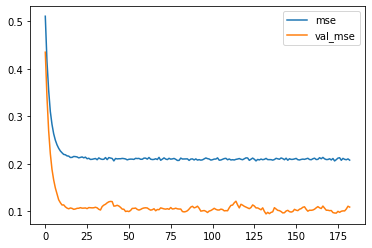

pred_col_name pbj_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

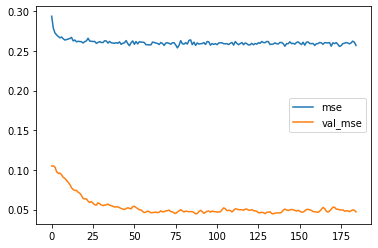

----------
Stock pairing = pej_bac
Pct finished = 0.7575757575757576
pred_col_name pej_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.

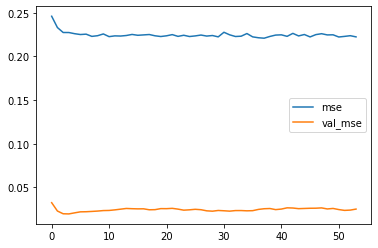

Prediction = 0.7670733332633972
Last corr = 0.657536
pred_col_name rop_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252

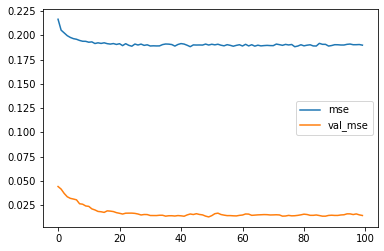

pred_col_name vti_atvi_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

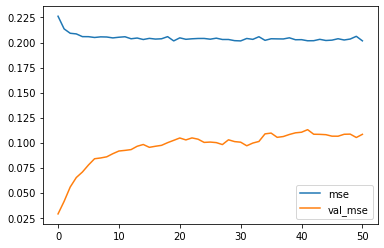

pred_col_name rost_ce_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

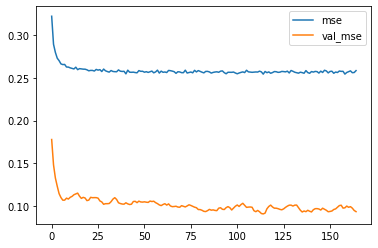

pred_col_name pbj_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

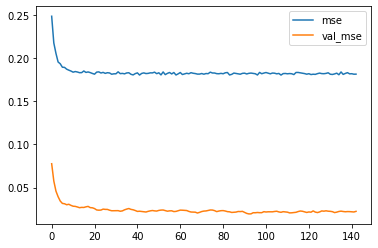

pred_col_name pbj_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

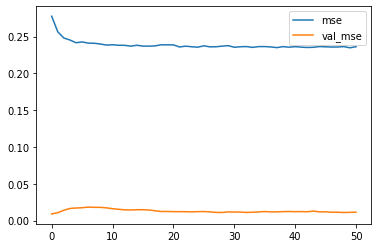

pred_col_name rost_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

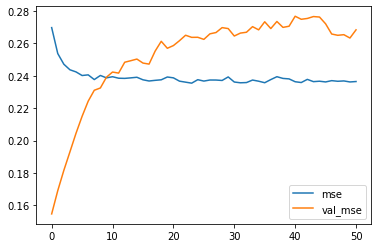

pred_col_name vti_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

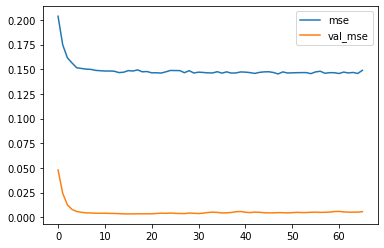

pred_col_name vti_qqq_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

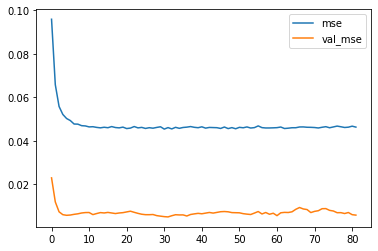

pred_col_name pbj_mgm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

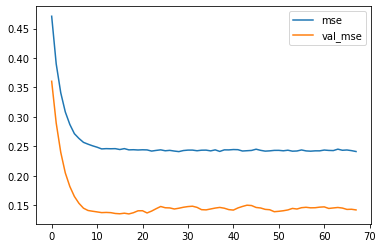

pred_col_name pg_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

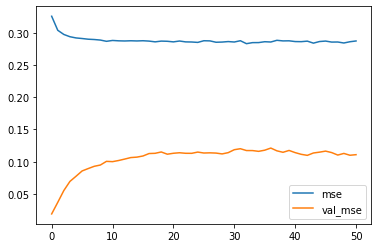

pred_col_name pej_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

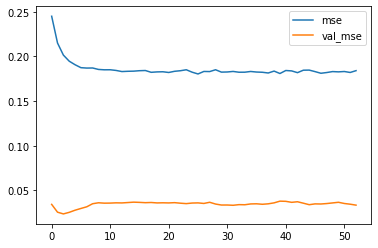

pred_col_name eqix_emr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

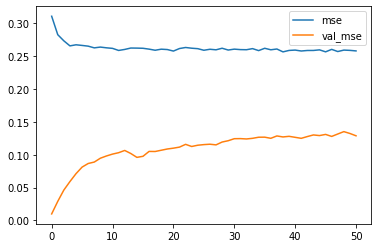

pred_col_name lb_pg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.939

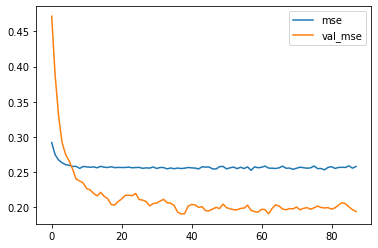

pred_col_name ce_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

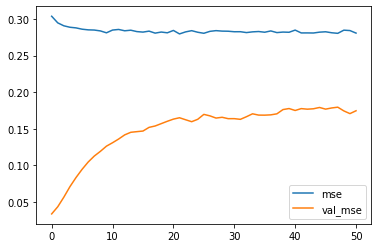

pred_col_name jpm_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

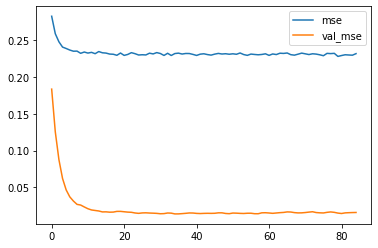

pred_col_name spy_pvh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

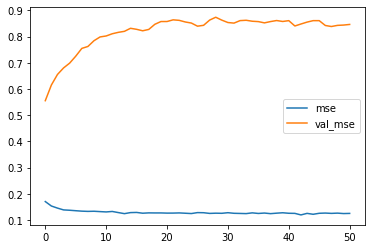

pred_col_name rost_vfh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

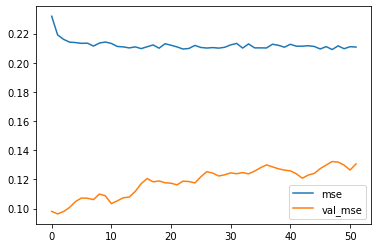

pred_col_name lb_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

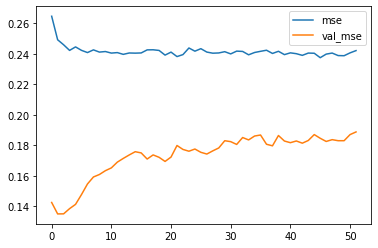

pred_col_name so_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

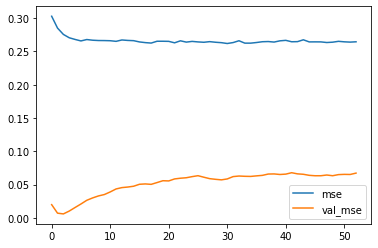

pred_col_name spy_vfh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

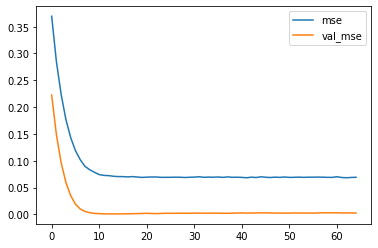

pred_col_name lb_dia_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

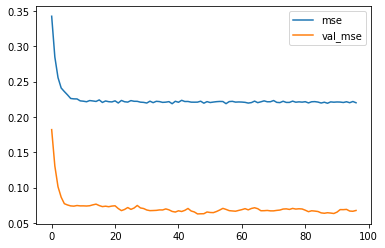

pred_col_name pvh_tjx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

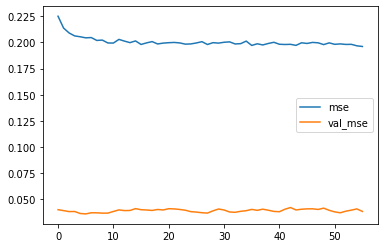

pred_col_name emr_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

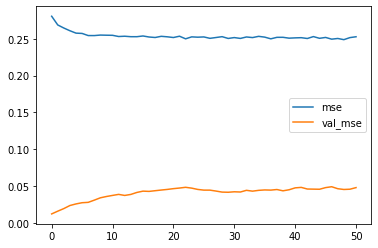

pred_col_name bac_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

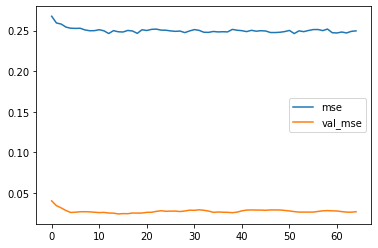

----------
Stock pairing = jpm_peg
Pct finished = 0.8049242424242424
pred_col_name jpm_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.

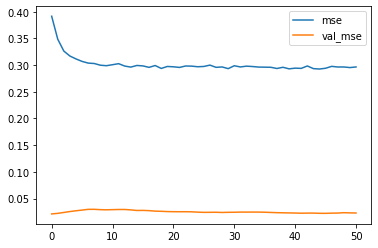

Prediction = 0.5925995707511902
Last corr = 0.510966
pred_col_name pg_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252


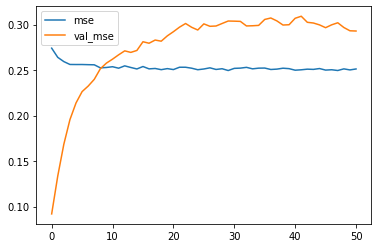

pred_col_name vti_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

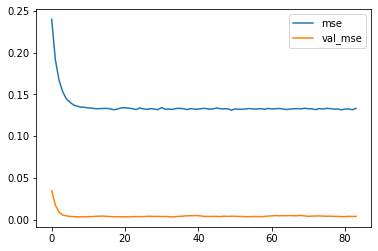

pred_col_name emr_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

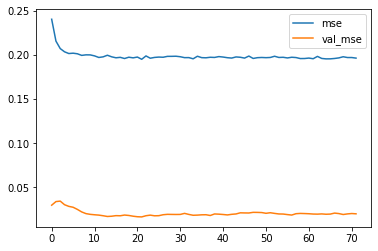

pred_col_name peg_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

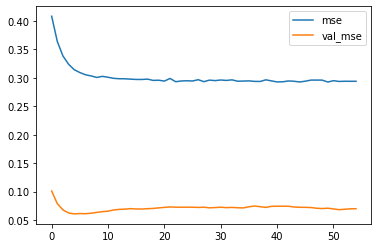

pred_col_name mgm_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

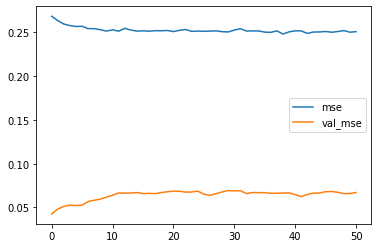

pred_col_name rop_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

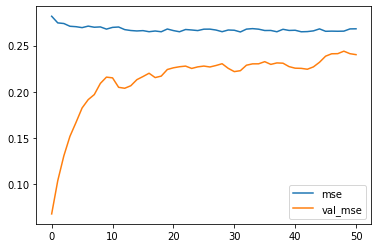

pred_col_name qqq_mgm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

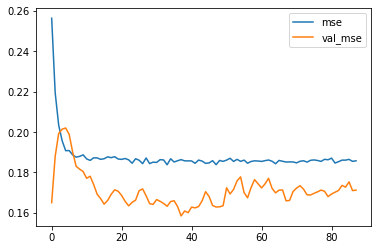

pred_col_name rost_lb_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

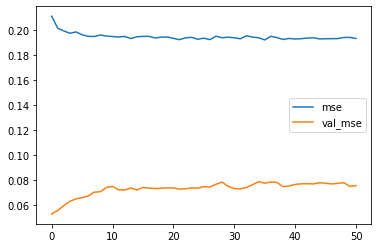

pred_col_name so_lb_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.939

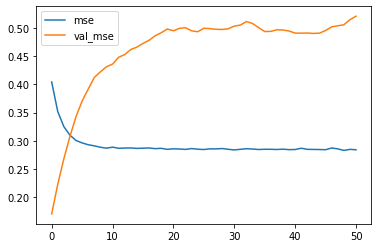

pred_col_name rost_iwm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

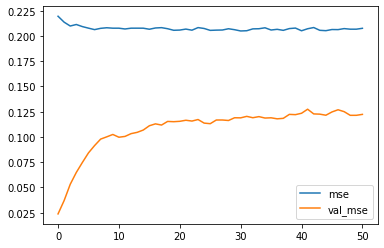

pred_col_name spy_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

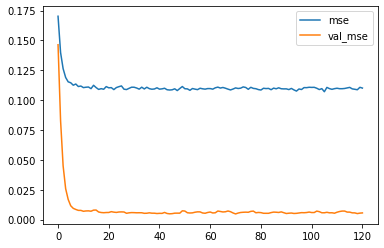

pred_col_name qqq_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

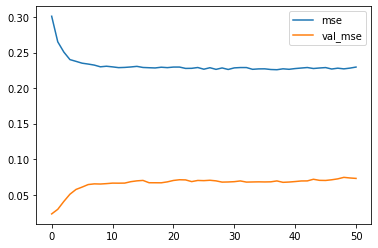

pred_col_name cern_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

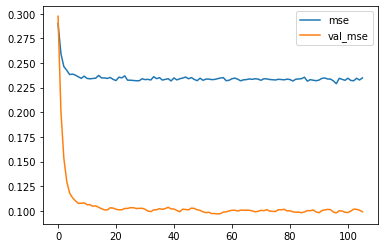

pred_col_name ce_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.939

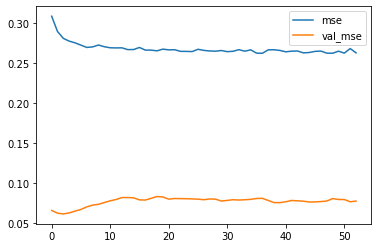

pred_col_name pej_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

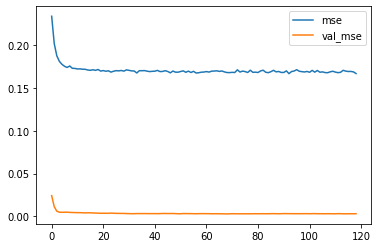

pred_col_name ni_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

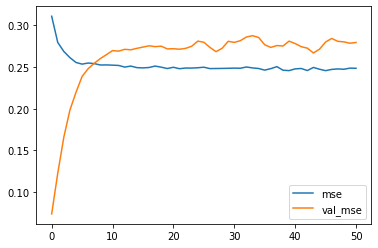

pred_col_name lb_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

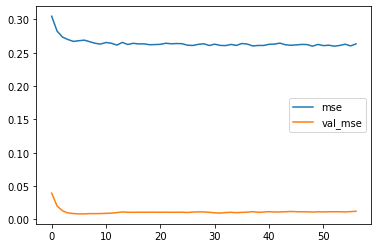

pred_col_name bac_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

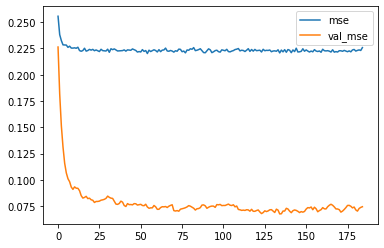

pred_col_name so_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

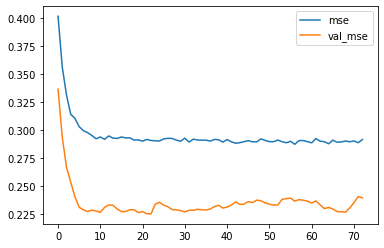

pred_col_name pvh_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

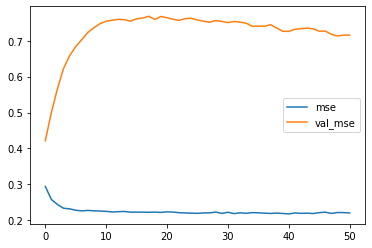

pred_col_name mgm_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

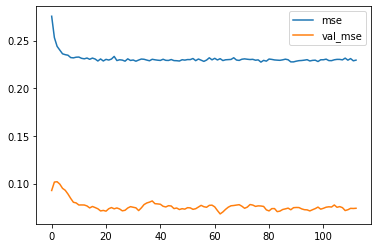

pred_col_name bac_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

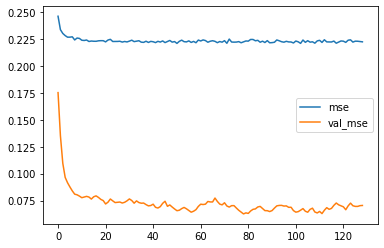

pred_col_name are_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

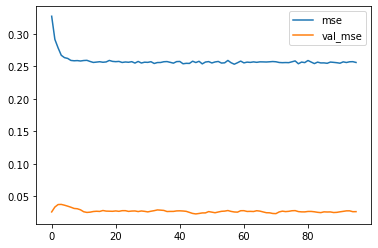

pred_col_name ce_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

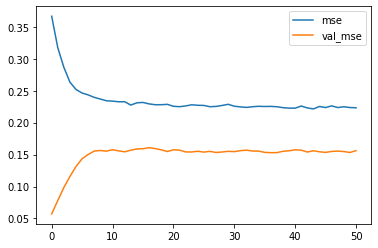

----------
Stock pairing = so_ual
Pct finished = 0.8522727272727273
pred_col_name so_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.86

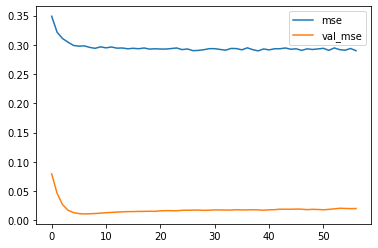

Prediction = 0.31436532735824585
Last corr = 0.286283
pred_col_name iwm_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252

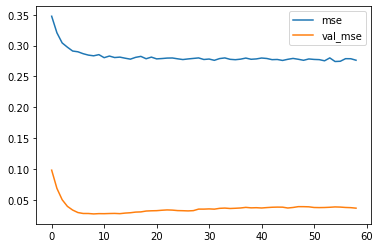

pred_col_name so_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

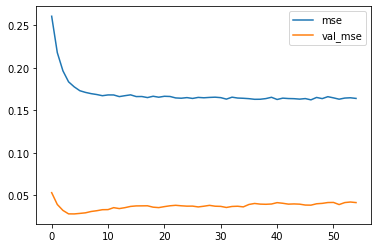

pred_col_name spy_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

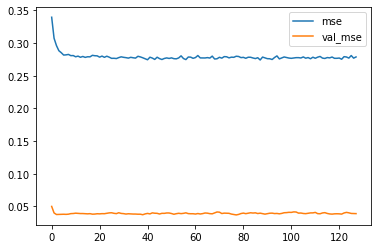

pred_col_name dia_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

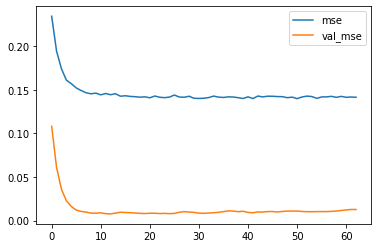

pred_col_name eqix_vfh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

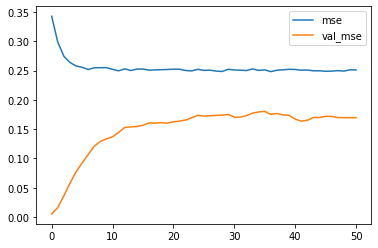

pred_col_name vfh_lb_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

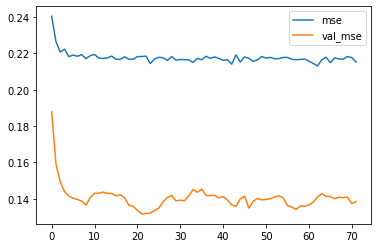

pred_col_name lb_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

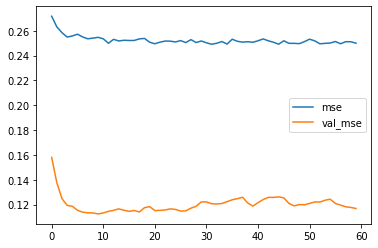

pred_col_name eqix_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

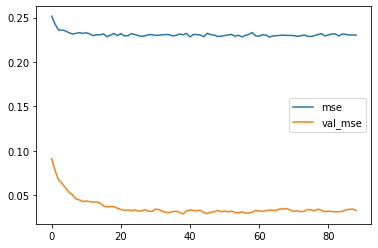

pred_col_name eqix_pg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

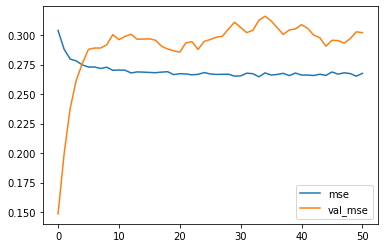

pred_col_name pnr_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

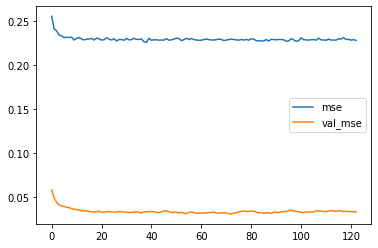

pred_col_name tjx_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

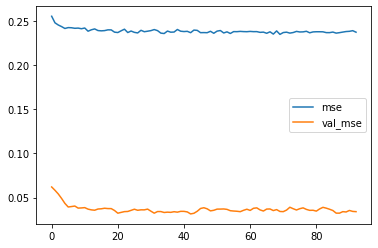

pred_col_name jpm_atvi_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

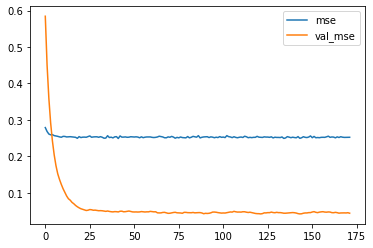

pred_col_name lb_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

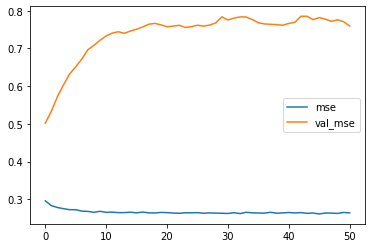

pred_col_name spy_atvi_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

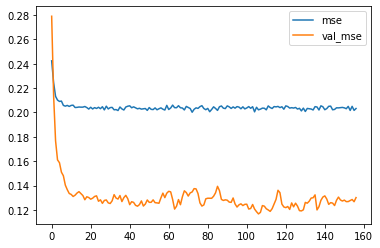

pred_col_name atvi_lb_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

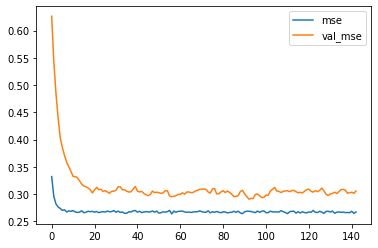

pred_col_name qqq_pg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

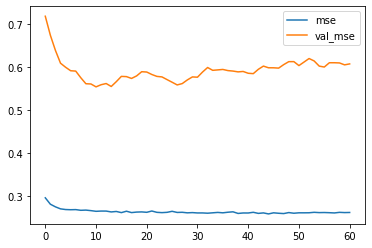

pred_col_name rop_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

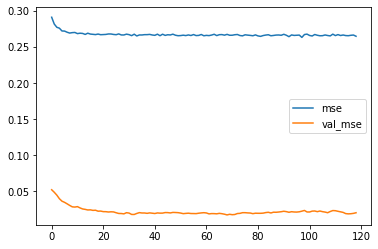

pred_col_name adbe_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

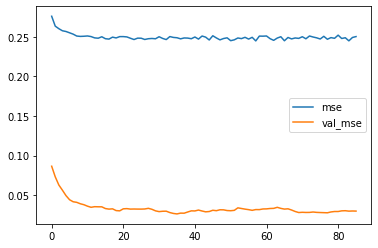

pred_col_name eqix_peg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

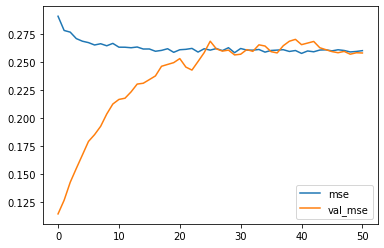

pred_col_name ce_pvh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

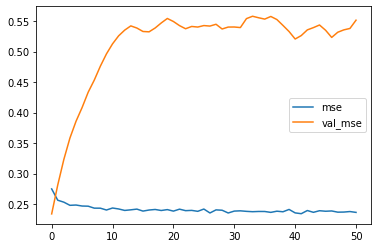

pred_col_name so_atvi_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

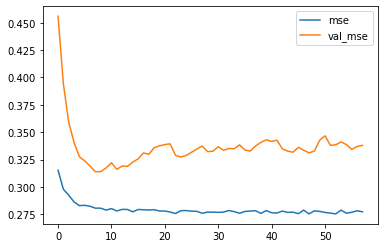

pred_col_name jpm_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

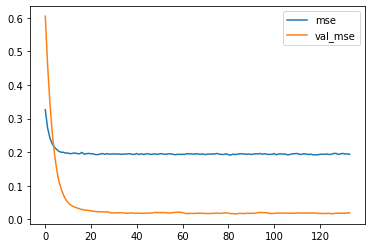

pred_col_name tjx_pg_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

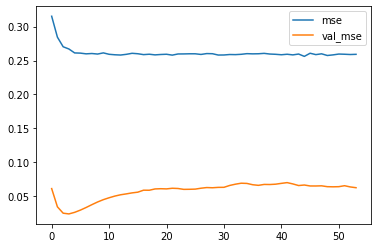

pred_col_name ce_lb_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.939

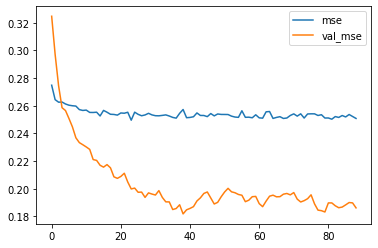

----------
Stock pairing = pej_xrt
Pct finished = 0.8996212121212122
pred_col_name pej_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.

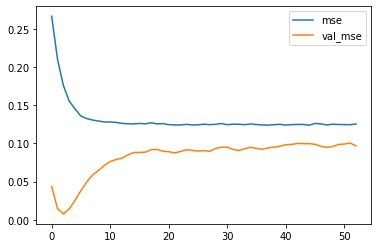

Prediction = 0.5291643738746643
Last corr = 0.499891
pred_col_name so_dia_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252


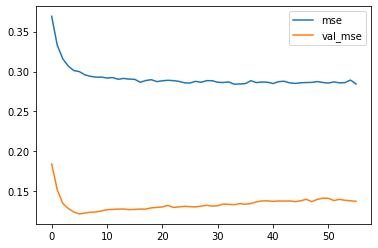

pred_col_name iwm_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

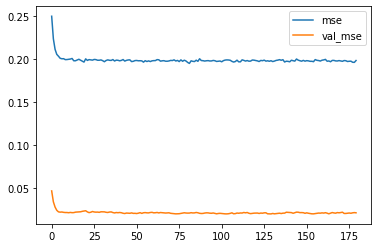

pred_col_name so_eqix_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

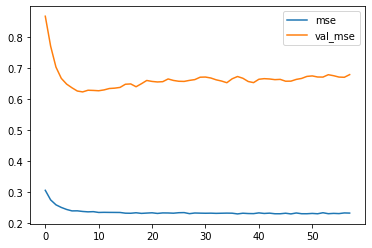

pred_col_name bjk_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

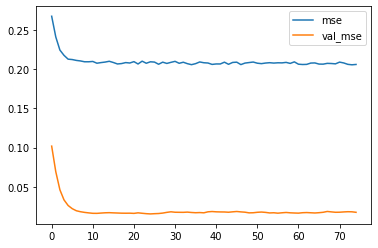

pred_col_name iwm_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

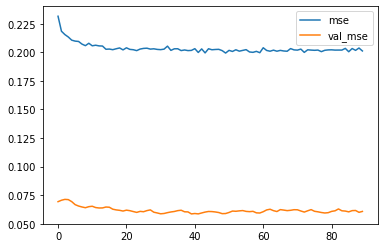

pred_col_name ce_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

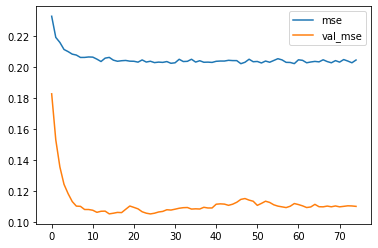

pred_col_name rost_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

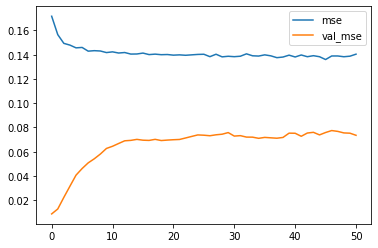

pred_col_name pvh_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

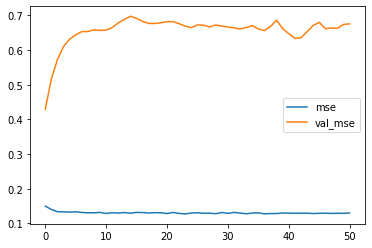

pred_col_name dia_cern_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

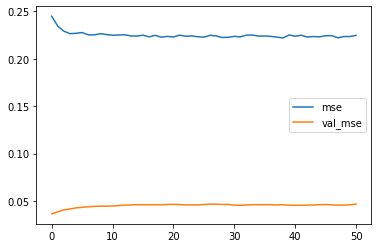

pred_col_name ual_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

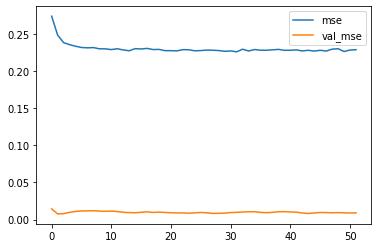

pred_col_name eqix_rop_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

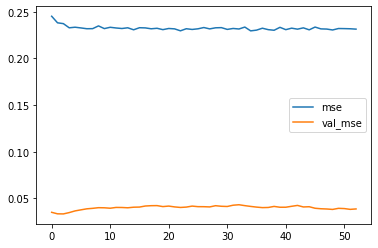

pred_col_name vfh_iwm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

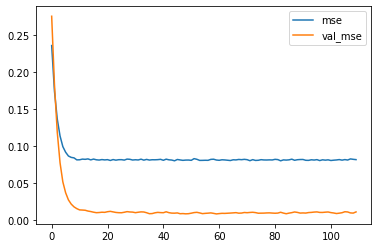

pred_col_name spy_lb_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

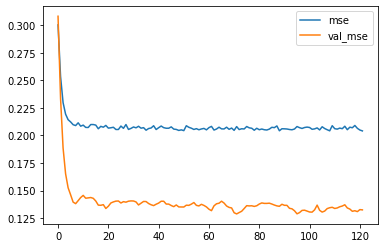

pred_col_name rost_tjx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

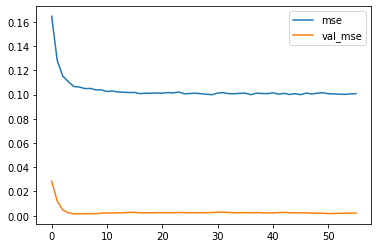

pred_col_name so_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

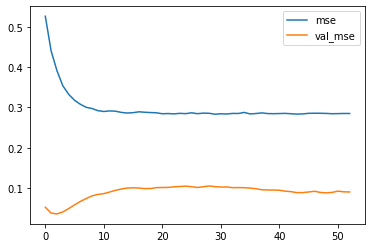

pred_col_name pbj_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

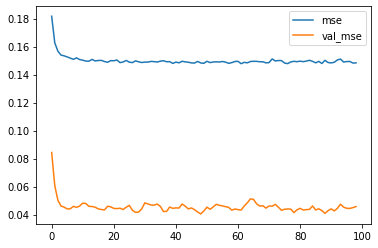

pred_col_name are_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

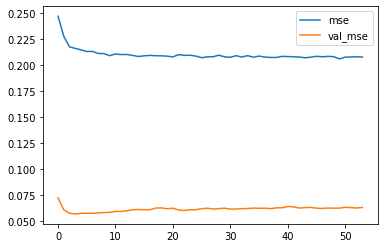

pred_col_name ce_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

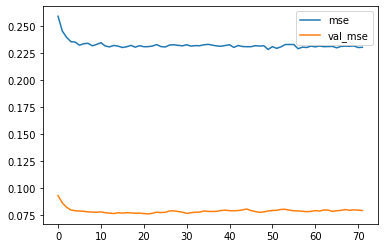

pred_col_name jpm_efx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

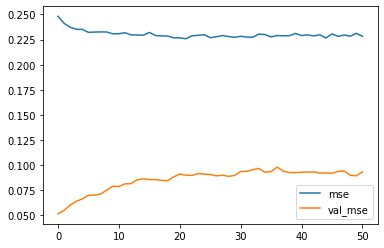

pred_col_name qqq_pvh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

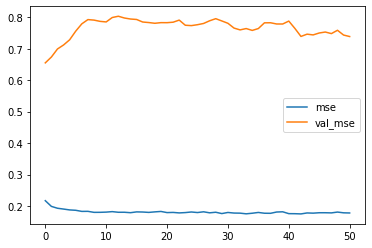

pred_col_name pvh_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

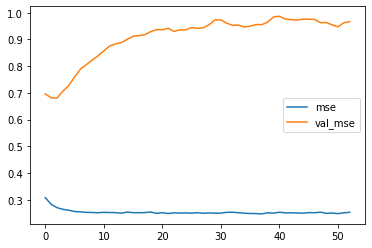

pred_col_name pbj_dia_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

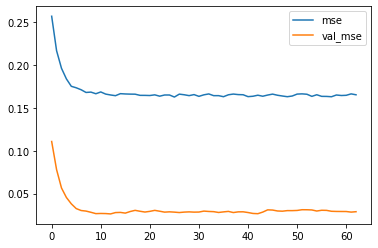

pred_col_name are_xrt_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

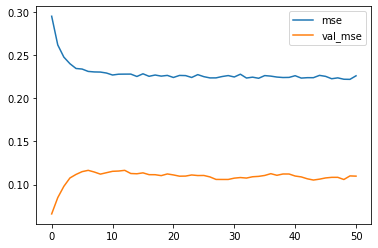

pred_col_name jpm_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

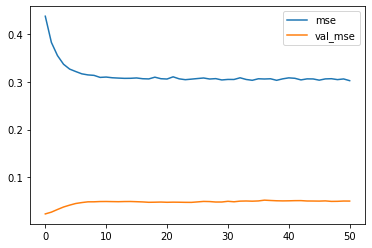

----------
Stock pairing = ce_ph
Pct finished = 0.946969696969697
pred_col_name ce_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.86986

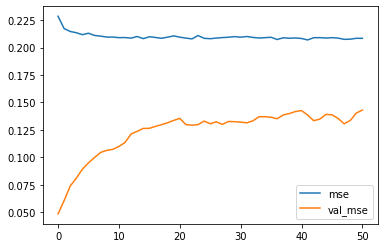

Prediction = 0.6628376245498657
Last corr = 0.838013
pred_col_name so_vfh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252


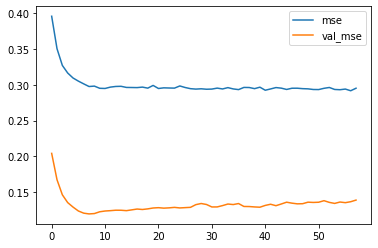

pred_col_name vfh_are_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

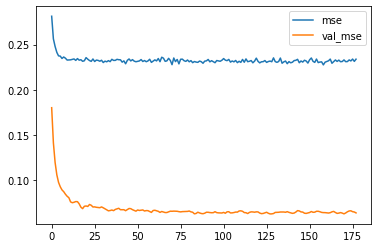

pred_col_name so_tjx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

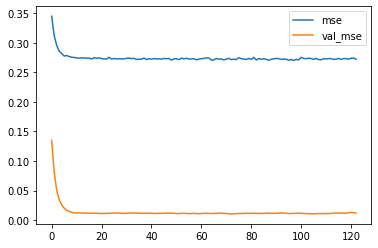

pred_col_name qqq_tjx_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

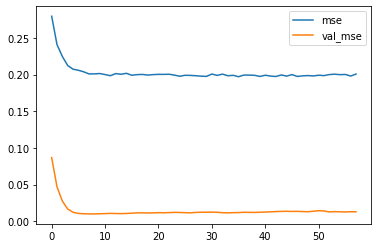

pred_col_name ce_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

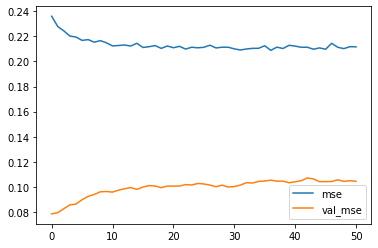

pred_col_name iwm_lb_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

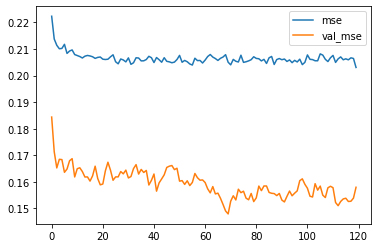

pred_col_name iwm_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

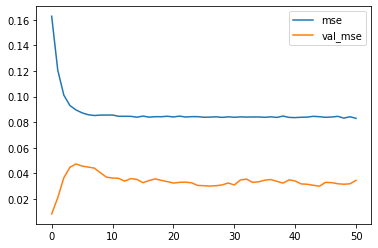

pred_col_name are_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

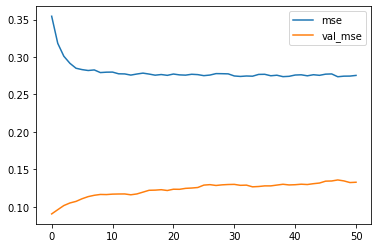

pred_col_name pej_bjk_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

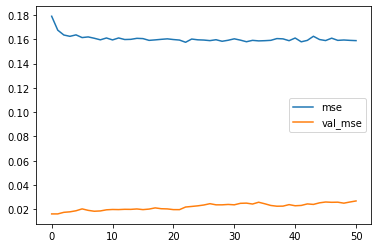

pred_col_name lb_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.939

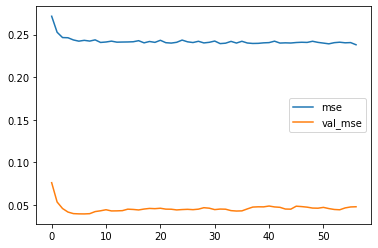

pred_col_name pbj_vti_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

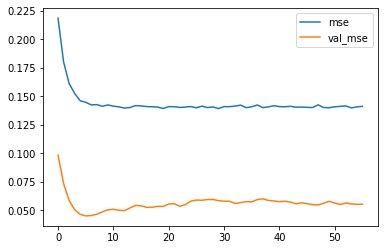

pred_col_name spy_ph_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

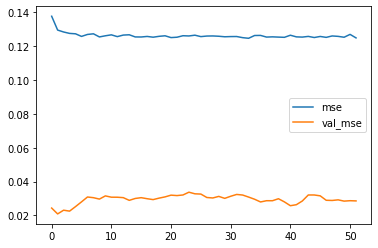

pred_col_name pbj_jpm_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

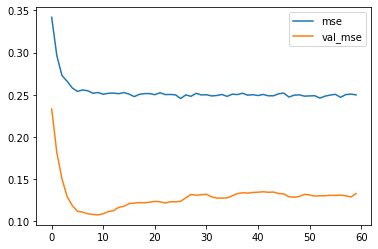

pred_col_name rost_pvh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

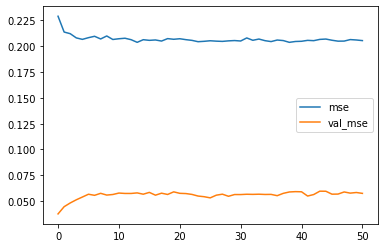

pred_col_name eqix_pnr_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

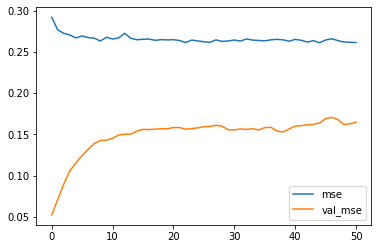

pred_col_name dia_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

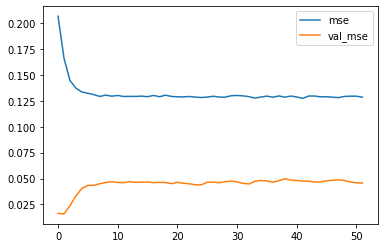

pred_col_name rost_ual_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

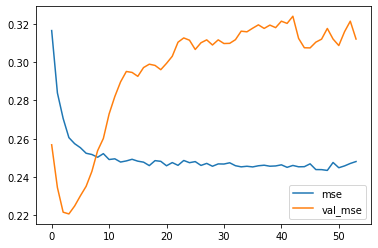

pred_col_name lb_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

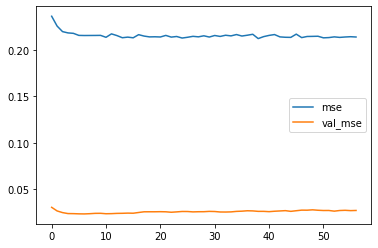

pred_col_name so_ce_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.939

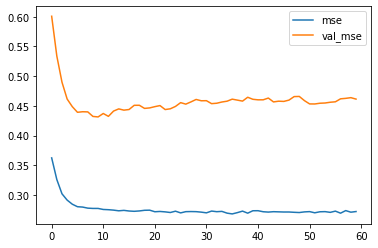

pred_col_name lb_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.939

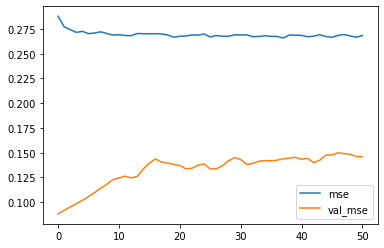

pred_col_name dia_ni_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

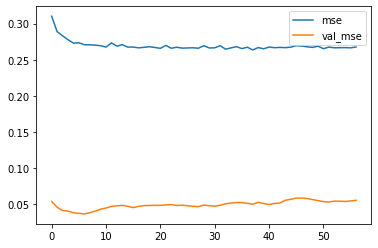

pred_col_name emr_pvh_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

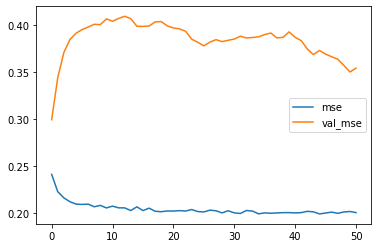

pred_col_name atvi_dia_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.

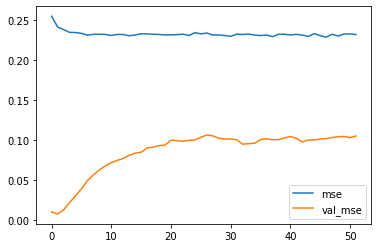

pred_col_name so_vti_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.93

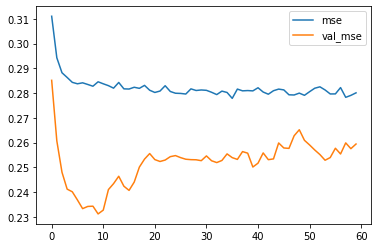

----------
Stock pairing = qqq_bac
Pct finished = 0.9943181818181818
pred_col_name qqq_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.

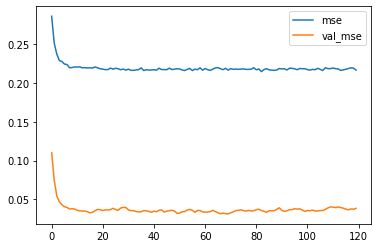

Prediction = 0.5442835688591003
Last corr = 0.733482
pred_col_name dia_bac_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252

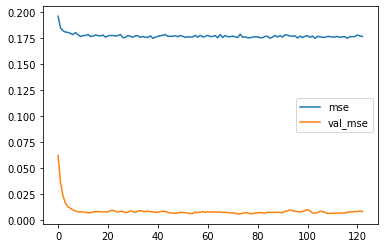

pred_col_name spy_pej_close_corr_rolling_7_days
n_sequences 2874
Training idx start at 0
Pct finished = 0.03479471120389701
Pct finished = 0.06958942240779402
Pct finished = 0.10438413361169102
Pct finished = 0.13917884481558804
Pct finished = 0.17397355601948503
Pct finished = 0.20876826722338204
Pct finished = 0.24356297842727906
Pct finished = 0.2783576896311761
Pct finished = 0.31315240083507306
Pct finished = 0.34794711203897005
Pct finished = 0.3827418232428671
Pct finished = 0.4175365344467641
Pct finished = 0.4523312456506611
Pct finished = 0.4871259568545581
Pct finished = 0.5219206680584552
Pct finished = 0.5567153792623522
Pct finished = 0.5915100904662491
Pct finished = 0.6263048016701461
Pct finished = 0.6610995128740431
Pct finished = 0.6958942240779401
Pct finished = 0.7306889352818372
Pct finished = 0.7654836464857342
Pct finished = 0.8002783576896312
Pct finished = 0.8350730688935282
Pct finished = 0.8698677800974252
Pct finished = 0.9046624913013221
Pct finished = 0.9

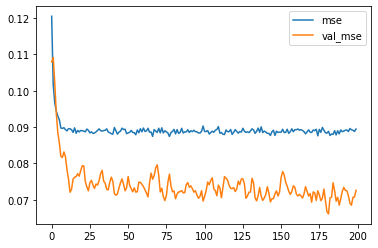

Predictions took 1109.298991282781 mins


In [551]:
# 6.5 minutes for 10 stocks
final_stock_df = final_stock_df.dropna()
# test 14 day period instead of 30
# no dice
# test smaller network smae LR
# no dice
# test since 2016 data
# no dice
# test smaller learning rate 
# no dice
# test smaller batch size
# nothing
# test batch size  


# so the solution was less validation data

# wal_cwbc is turns out needed less training data

# test a new model for each pair, 200 epochs per . 2 minutes per 200 epochs
# 300 pairs take 10 hours sequentially
# X,y, X_val, y_val, scalers, pca_scalers 
prediction_for_upcoming_week(final_stock_df, pairs_of_stocks, input_verbose=0)

In [ ]:
training_data

In [ ]:
np.isnan(X_val).sum()

In [1021]:
np.isnan(new_X_test).sum()

0